In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LOADING UENT MODEL



In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import pickle
import numpy as np
import os

# Define the directory in Google Drive
drive_directory = '/content/drive/MyDrive/UNET_MODEL'

# Define file paths
model_save_path = os.path.join(drive_directory, 'unet_final_model.keras')
model_save_path_h5 = os.path.join(drive_directory, 'unet_final_model.h5')
history_save_path = os.path.join(drive_directory, 'training_history.pkl')
predictions_save_path = os.path.join(drive_directory, 'model_predictions.npy')

# Define custom functions
@tf.keras.utils.register_keras_serializable()
def weighted_binary_crossentropy(weights):
    @tf.keras.utils.register_keras_serializable()
    def loss(y_true, y_pred):
        y_true = tf.keras.backend.flatten(y_true)
        y_pred = tf.keras.backend.flatten(y_pred)
        loss = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        loss = loss * (weights[1] * y_true + weights[0] * (1 - y_true))
        return tf.keras.backend.mean(loss)
    return loss

#weights = [0.015, 0.98]
weights = [0.1, 0.9]
@tf.keras.utils.register_keras_serializable()
def iou_metric(y_true, y_pred):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    iou = intersection / (union + tf.keras.backend.epsilon())
    return iou
@tf.keras.utils.register_keras_serializable()
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) + smooth)

# Load the model using the absolute path
if os.path.exists(model_save_path):
    model = load_model(model_save_path, custom_objects={
        'weighted_binary_crossentropy': weighted_binary_crossentropy(weights),
        'iou_metric': iou_metric,
        'dice_coefficient': dice_coefficient
    })
    print("Model loaded successfully from .keras file.")
else:
    print("Model file (.keras) does not exist.")

    # Load the training history
with open(history_save_path, 'rb') as f:
    history = pickle.load(f)

# Load the predictions
predictions = np.load(predictions_save_path)

# Display the loaded model summary
model.summary()

# Display the loaded training history
print("Training history keys:", history.keys())
for key, value in history.items():
    print(f"{key}: {value}")

# Display a few predictions
print("Predictions shape:", predictions.shape)
print("First prediction example:", predictions[0])

Model loaded successfully from .keras file.
Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_285 (Conv2D)         (None, 128, 128, 64)         640       ['input_20[0][0]']            
                                                                                                  
 dropout_133 (Dropout)       (None, 128, 128, 64)         0         ['conv2d_285[0][0]']          
                                                                                                  
 conv2d_286 (Conv2D)         (None, 128, 128, 64)         36928     ['dropout_133[0][0]']         
                                               

**WEIGHTS**

In [ ]:
import numpy as np

def extract_keras_weights(model):
    weights_dict = {}
    for layer in model.layers:
        layer_weights = layer.get_weights()
        if layer_weights:
            weights_dict[layer.name] = layer_weights
    return weights_dict

# Assuming `model` is your loaded Keras model
keras_weights = extract_keras_weights(model)


In [ ]:
import torch

def convert_weights_to_pytorch(keras_weights, pytorch_model):
    for name, param in pytorch_model.named_parameters():
        layer_name = name.split('.')[0]
        if layer_name in keras_weights:
            weight, bias = keras_weights[layer_name]
            param.data.copy_(torch.tensor(weight.transpose(3, 2, 0, 1)))  # For Conv2d layers
            param.bias.data.copy_(torch.tensor(bias))


# **DSConv**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Conv2d, GroupNorm, ReLU
from torch.utils.data import Dataset, DataLoader

# Define DSConv class
class DSConv(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, extend_scope, morph, if_offset, device):
        super(DSConv, self).__init__()
        self.offset_conv = nn.Conv2d(in_ch, 2 * kernel_size, 3, padding=1)
        self.bn = nn.BatchNorm2d(2 * kernel_size)
        self.kernel_size = kernel_size
        self.dsc_conv_x = nn.Conv2d(
            in_ch,
            out_ch,
            kernel_size=(kernel_size, 1),
            stride=(kernel_size, 1),
            padding=0,
        )
        self.dsc_conv_y = nn.Conv2d(
            in_ch,
            out_ch,
            kernel_size=(1, kernel_size),
            stride=(1, kernel_size),
            padding=0,
        )
        self.gn = nn.GroupNorm(out_ch // 4, out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.extend_scope = extend_scope
        self.morph = morph
        self.if_offset = if_offset
        self.device = device

    def forward(self, f):
        offset = self.offset_conv(f)
        offset = self.bn(offset)
        offset = torch.tanh(offset)
        input_shape = f.shape
        dsc = DSC(input_shape, self.kernel_size, self.extend_scope, self.morph, self.device)
        deformed_feature = dsc.deform_conv(f, offset, self.if_offset)
        if self.morph == 0:
            x = self.dsc_conv_x(deformed_feature)
            x = self.gn(x)
            x = self.relu(x)
            return x
        else:
            x = self.dsc_conv_y(deformed_feature)
            x = self.gn(x)
            x = self.relu(x)
            return x

class DSC(object):
    def __init__(self, input_shape, kernel_size, extend_scope, morph, device):
        self.num_points = kernel_size
        self.width = input_shape[2]
        self.height = input_shape[3]
        self.morph = morph
        self.device = device
        self.extend_scope = extend_scope
        self.num_batch = input_shape[0]
        self.num_channels = input_shape[1]

    def _coordinate_map_3D(self, offset, if_offset):
        y_offset, x_offset = torch.split(offset, self.num_points, dim=1)
        y_center = torch.arange(0, self.width).repeat([self.height])
        y_center = y_center.reshape(self.height, self.width)
        y_center = y_center.permute(1, 0)
        y_center = y_center.reshape([-1, self.width, self.height])
        y_center = y_center.repeat([self.num_points, 1, 1]).float()
        y_center = y_center.unsqueeze(0)
        x_center = torch.arange(0, self.height).repeat([self.width])
        x_center = x_center.reshape(self.width, self.height)
        x_center = x_center.permute(0, 1)
        x_center = x_center.reshape([-1, self.width, self.height])
        x_center = x_center.repeat([self.num_points, 1, 1]).float()
        x_center = x_center.unsqueeze(0)
        if self.morph == 0:
            y = torch.linspace(0, 0, 1)
            x = torch.linspace(-int(self.num_points // 2), int(self.num_points // 2), int(self.num_points))
            y, x = torch.meshgrid(y, x)
            y_spread = y.reshape(-1, 1)
            x_spread = x.reshape(-1, 1)
            y_grid = y_spread.repeat([1, self.width * self.height])
            y_grid = y_grid.reshape([self.num_points, self.width, self.height])
            y_grid = y_grid.unsqueeze(0)
            x_grid = x_spread.repeat([1, self.width * self.height])
            x_grid = x_grid.reshape([self.num_points, self.width, self.height])
            x_grid = x_grid.unsqueeze(0)
            y_new = y_center + y_grid
            x_new = x_center + x_grid
            y_new = y_new.repeat(self.num_batch, 1, 1, 1).to(self.device)
            x_new = x_new.repeat(self.num_batch, 1, 1, 1).to(self.device)
            y_offset_new = y_offset.detach().clone()
            if if_offset:
                y_offset = y_offset.permute(1, 0, 2, 3)
                y_offset_new = y_offset_new.permute(1, 0, 2, 3)
                center = int(self.num_points // 2)
                y_offset_new[center] = 0
                for index in range(1, center):
                    y_offset_new[center + index] = (y_offset_new[center + index - 1] + y_offset[center + index])
                    y_offset_new[center - index] = (y_offset_new[center - index + 1] + y_offset[center - index])
                y_offset_new = y_offset_new.permute(1, 0, 2, 3).to(self.device)
                y_new = y_new.add(y_offset_new.mul(self.extend_scope))
            y_new = y_new.reshape([self.num_batch, self.num_points, 1, self.width, self.height])
            y_new = y_new.permute(0, 3, 1, 4, 2)
            y_new = y_new.reshape([self.num_batch, self.num_points * self.width, 1 * self.height])
            x_new = x_new.reshape([self.num_batch, self.num_points, 1, self.width, self.height])
            x_new = x_new.permute(0, 3, 1, 4, 2)
            x_new = x_new.reshape([self.num_batch, self.num_points * self.width, 1 * self.height])
            return y_new, x_new
        else:
            y = torch.linspace(-int(self.num_points // 2), int(self.num_points // 2), int(self.num_points))
            x = torch.linspace(0, 0, 1)
            y, x = torch.meshgrid(y, x)
            y_spread = y.reshape(-1, 1)
            x_spread = x.reshape(-1, 1)
            y_grid = y_spread.repeat([1, self.width * self.height])
            y_grid = y_grid.reshape([self.num_points, self.width, self.height])
            y_grid = y_grid.unsqueeze(0)
            x_grid = x_spread.repeat([1, self.width * self.height])
            x_grid = x_grid.reshape([self.num_points, self.width, self.height])
            x_grid = x_grid.unsqueeze(0)
            y_new = y_center + y_grid
            x_new = x_center + x_grid
            y_new = y_new.repeat(self.num_batch, 1, 1, 1)
            x_new = x_new.repeat(self.num_batch, 1, 1, 1)
            y_new = y_new.to(self.device)
            x_new = x_new.to(self.device)
            x_offset_new = x_offset.detach().clone()
            if if_offset:
                x_offset = x_offset.permute(1, 0, 2, 3)
                x_offset_new = x_offset_new.permute(1, 0, 2, 3)
                center = int(self.num_points // 2)
                x_offset_new[center] = 0
                for index in range(1, center):
                    x_offset_new[center + index] = (x_offset_new[center + index - 1] + x_offset[center + index])
                    x_offset_new[center - index] = (x_offset_new[center - index + 1] + x_offset[center - index])
                x_offset_new = x_offset_new.permute(1, 0, 2, 3).to(self.device)
                x_new = x_new.add(x_offset_new.mul(self.extend_scope))
            y_new = y_new.reshape([self.num_batch, 1, self.num_points, self.width, self.height])
            y_new = y_new.permute(0, 3, 1, 4, 2)
            y_new = y_new.reshape([self.num_batch, 1 * self.width, self.num_points * self.height])
            x_new = x_new.reshape([self.num_batch, 1, self.num_points, self.width, self.height])
            x_new = x_new.permute(0, 3, 1, 4, 2)
            x_new = x_new.reshape([self.num_batch, 1 * self.width, self.num_points * self.height])
            return y_new, x_new

    def _bilinear_interpolate_3D(self, input_feature, y, x):
        y = y.reshape([-1]).float()
        x = x.reshape([-1]).float()
        zero = torch.zeros([]).int()
        max_y = self.width - 1
        max_x = self.height - 1
        y0 = torch.floor(y).int()
        y1 = y0 + 1
        x0 = torch.floor(x).int()
        x1 = x0 + 1
        y0 = torch.clamp(y0, zero, max_y)
        y1 = torch.clamp(y1, zero, max_y)
        x0 = torch.clamp(x0, zero, max_x)
        x1 = torch.clamp(x1, zero, max_x)
        input_feature_flat = input_feature.flatten()
        input_feature_flat = input_feature_flat.reshape(self.num_batch, self.num_channels, self.width, self.height)
        input_feature_flat = input_feature_flat.permute(0, 2, 3, 1)
        input_feature_flat = input_feature_flat.reshape(-1, self.num_channels)
        dimension = self.height * self.width
        base = torch.arange(self.num_batch) * dimension
        base = base.reshape([-1, 1]).float()
        repeat = torch.ones([self.num_points * self.width * self.height]).unsqueeze(0)
        repeat = repeat.float()
        base = torch.matmul(base, repeat)
        base = base.reshape([-1])
        base = base.to(self.device)
        base_y0 = base + y0 * self.height
        base_y1 = base + y1 * self.height
        index_a0 = base_y0 - base + x0
        index_c0 = base_y0 - base + x1
        index_a1 = base_y1 - base + x0
        index_c1 = base_y1 - base + x1
        value_a0 = input_feature_flat[index_a0.type(torch.int64)].to(self.device)
        value_c0 = input_feature_flat[index_c0.type(torch.int64)].to(self.device)
        value_a1 = input_feature_flat[index_a1.type(torch.int64)].to(self.device)
        value_c1 = input_feature_flat[index_c1.type(torch.int64)].to(self.device)
        y0 = torch.floor(y).int()
        y1 = y0 + 1
        x0 = torch.floor(x).int()
        x1 = x0 + 1
        y0 = torch.clamp(y0, zero, max_y + 1)
        y1 = torch.clamp(y1, zero, max_y + 1)
        x0 = torch.clamp(x0, zero, max_x + 1)
        x1 = torch.clamp(x1, zero, max_x + 1)
        x0_float = x0.float()
        x1_float = x1.float()
        y0_float = y0.float()
        y1_float = y1.float()
        vol_a0 = ((y1_float - y) * (x1_float - x)).unsqueeze(-1).to(self.device)
        vol_c0 = ((y1_float - y) * (x - x0_float)).unsqueeze(-1).to(self.device)
        vol_a1 = ((y - y0_float) * (x1_float - x)).unsqueeze(-1).to(self.device)
        vol_c1 = ((y - y0_float) * (x - x0_float)).unsqueeze(-1).to(self.device)
        outputs = (value_a0 * vol_a0 + value_c0 * vol_c0 + value_a1 * vol_a1 + value_c1 * vol_c1)
        if self.morph == 0:
            outputs = outputs.reshape([self.num_batch, self.num_points * self.width, 1 * self.height, self.num_channels])
            outputs = outputs.permute(0, 3, 1, 2)
        else:
            outputs = outputs.reshape([self.num_batch, 1 * self.width, self.num_points * self.height, self.num_channels])
            outputs = outputs.permute(0, 3, 1, 2)
        return outputs

    def deform_conv(self, input, offset, if_offset):
        y, x = self._coordinate_map_3D(offset, if_offset)
        deformed_feature = self._bilinear_interpolate_3D(input, y, x)
        return deformed_feature


**DSCNet**

In [ ]:
import torch
from torch import nn, cat



# Define EncoderConv class
class EncoderConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(EncoderConv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.gn = nn.GroupNorm(out_ch // 4, out_ch)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.gn(x)
        x = self.relu(x)
        return x

# Define DecoderConv class
class DecoderConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DecoderConv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.gn = nn.GroupNorm(out_ch // 4, out_ch)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.gn(x)
        x = self.relu(x)
        return x

# Define DSCNet class
class DSCNet(nn.Module):
    def __init__(
        self,
        n_channels,
        n_classes,
        kernel_size,
        extend_scope,
        if_offset,
        device,
        number,
        dim,
        pretrained_weights=None
    ):
        super(DSCNet, self).__init__()
        self.device = device
        self.kernel_size = kernel_size
        self.extend_scope = extend_scope
        self.if_offset = if_offset
        self.relu = nn.ReLU(inplace=True)
        self.number = number
        self.dim = dim
        self.conv00 = EncoderConv(n_channels, self.number)
        self.conv0x = DSConv(
            n_channels,
            self.number,
            self.kernel_size,
            self.extend_scope,
            0,
            self.if_offset,
            self.device,
        )
        self.conv0y = DSConv(
            n_channels,
            self.number,
            self.kernel_size,
            self.extend_scope,
            1,
            self.if_offset,
            self.device,
        )
        self.conv1 = EncoderConv(3 * self.number, self.number)
        self.conv20 = EncoderConv(self.number, 2 * self.number)
        self.conv2x = DSConv(
            self.number,
            2 * self.number,
            self.kernel_size,
            self.extend_scope,
            0,
            self.if_offset,
            self.device,
        )
        self.conv2y = DSConv(
            self.number,
            2 * self.number,
            self.kernel_size,
            self.extend_scope,
            1,
            self.if_offset,
            self.device,
        )
        self.conv3 = EncoderConv(6 * self.number, 2 * self.number)
        self.conv40 = EncoderConv(2 * self.number, 4 * self.number)
        self.conv4x = DSConv(
            2 * self.number,
            4 * self.number,
            self.kernel_size,
            self.extend_scope,
            0,
            self.if_offset,
            self.device,
        )
        self.conv4y = DSConv(
            2 * self.number,
            4 * self.number,
            self.kernel_size,
            self.extend_scope,
            1,
            self.if_offset,
            self.device,
        )
        self.conv5 = EncoderConv(12 * self.number, 4 * self.number)
        self.conv60 = EncoderConv(4 * self.number, 8 * self.number)
        self.conv6x = DSConv(
            4 * self.number,
            8 * self.number,
            self.kernel_size,
            self.extend_scope,
            0,
            self.if_offset,
            self.device,
        )
        self.conv6y = DSConv(
            4 * self.number,
            8 * self.number,
            self.kernel_size,
            self.extend_scope,
            1,
            self.if_offset,
            self.device,
        )
        self.conv7 = EncoderConv(24 * self.number, 8 * self.number)
        self.conv120 = EncoderConv(12 * self.number, 4 * self.number)
        self.conv12x = DSConv(
            12 * self.number,
            4 * self.number,
            self.kernel_size,
            self.extend_scope,
            0,
            self.if_offset,
            self.device,
        )
        self.conv12y = DSConv(
            12 * self.number,
            4 * self.number,
            self.kernel_size,
            self.extend_scope,
            1,
            self.if_offset,
            self.device,
        )
        self.conv13 = EncoderConv(12 * self.number, 4 * self.number)
        self.conv140 = DecoderConv(6 * self.number, 2 * self.number)
        self.conv14x = DSConv(
            6 * self.number,
            2 * self.number,
            self.kernel_size,
            self.extend_scope,
            0,
            self.if_offset,
            self.device,
        )
        self.conv14y = DSConv(
            6 * self.number,
            2 * self.number,
            self.kernel_size,
            self.extend_scope,
            1,
            self.if_offset,
            self.device,
        )
        self.conv15 = DecoderConv(6 * self.number, 2 * self.number)
        self.conv160 = DecoderConv(3 * self.number, self.number)
        self.conv16x = DSConv(
            3 * self.number,
            self.number,
            self.kernel_size,
            self.extend_scope,
            0,
            self.if_offset,
            self.device,
        )
        self.conv16y = DSConv(
            3 * self.number,
            self.number,
            self.kernel_size,
            self.extend_scope,
            1,
            self.if_offset,
            self.device,
        )
        self.conv17 = DecoderConv(3 * self.number, self.number)
        self.out_conv = nn.Conv2d(self.number, n_classes, 1)
        self.maxpooling = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # block0
        x_00_0 = self.conv00(x)
        x_0x_0 = self.conv0x(x)
        x_0y_0 = self.conv0y(x)
        x_0_1 = self.conv1(torch.cat([x_00_0, x_0x_0, x_0y_0], dim=1))
        print(f"Block 0 Output: {x_0_1.mean()}, {x_0_1.min()}, {x_0_1.max()}")  # Debug

        # block1
        x = self.maxpooling(x_0_1)
        x_20_0 = self.conv20(x)
        x_2x_0 = self.conv2x(x)
        x_2y_0 = self.conv2y(x)
        x_1_1 = self.conv3(torch.cat([x_20_0, x_2x_0, x_2y_0], dim=1))
        print(f"Block 1 Output: {x_1_1.mean()}, {x_1_1.min()}, {x_1_1.max()}")  # Debug

        # block2
        x = self.maxpooling(x_1_1)
        x_40_0 = self.conv40(x)
        x_4x_0 = self.conv4x(x)
        x_4y_0 = self.conv4y(x)
        x_2_1 = self.conv5(torch.cat([x_40_0, x_4x_0, x_4y_0], dim=1))
        print(f"Block 2 Output: {x_2_1.mean()}, {x_2_1.min()}, {x_2_1.max()}")  # Debug

        # block3
        x = self.maxpooling(x_2_1)
        x_60_0 = self.conv60(x)
        x_6x_0 = self.conv6x(x)
        x_6y_0 = self.conv6y(x)
        x_3_1 = self.conv7(torch.cat([x_60_0, x_6x_0, x_6y_0], dim=1))
        print(f"Block 3 Output: {x_3_1.mean()}, {x_3_1.min()}, {x_3_1.max()}")  # Debug

        # block4
        x = self.up(x_3_1)
        x_120_2 = self.conv120(torch.cat([x, x_2_1], dim=1))
        x_12x_2 = self.conv12x(torch.cat([x, x_2_1], dim=1))
        x_12y_2 = self.conv12y(torch.cat([x, x_2_1], dim=1))
        x_2_3 = self.conv13(torch.cat([x_120_2, x_12x_2, x_12y_2], dim=1))
        print(f"Block 4 Output: {x_2_3.mean()}, {x_2_3.min()}, {x_2_3.max()}")  # Debug

        # block5
        x = self.up(x_2_3)
        x_140_2 = self.conv140(torch.cat([x, x_1_1], dim=1))
        x_14x_2 = self.conv14x(torch.cat([x, x_1_1], dim=1))
        x_14y_2 = self.conv14y(torch.cat([x, x_1_1], dim=1))
        x_1_3 = self.conv15(torch.cat([x_140_2, x_14x_2, x_14y_2], dim=1))
        print(f"Block 5 Output: {x_1_3.mean()}, {x_1_3.min()}, {x_1_3.max()}")  # Debug

        # block6
        x = self.up(x_1_3)
        x_160_2 = self.conv160(torch.cat([x, x_0_1], dim=1))
        x_16x_2 = self.conv16x(torch.cat([x, x_0_1], dim=1))
        x_16y_2 = self.conv16y(torch.cat([x, x_0_1], dim=1))
        x_0_3 = self.conv17(torch.cat([x_160_2, x_16x_2, x_16y_2], dim=1))
        print(f"Block 6 Output: {x_0_3.mean()}, {x_0_3.min()}, {x_0_3.max()}")  # Debug

        # x = self.dropout(x)
        out = self.out_conv(x_0_3)
        out = self.sigmoid(out)
        return out


In [ ]:
pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 47.6 MB/s eta 0:00:00


DATA **LOADER**

# **THE ONE TO USE**

In [ ]:
import os
import SimpleITK as sitk
import numpy as np
import torch
from torch.utils import data
import random

# Function to resample images
def resample_image(image, new_size, interpolator=sitk.sitkLinear):
    original_size = image.GetSize()
    original_spacing = image.GetSpacing()
    new_spacing = [
        original_spacing[0] * (original_size[0] / new_size[0]),
        original_spacing[1] * (original_size[1] / new_size[1])
    ]

    resampled_image = sitk.Resample(
        image, new_size, sitk.Transform(), interpolator,
        image.GetOrigin(), new_spacing, image.GetDirection(), 0, image.GetPixelID()
    )
    return resampled_image

# Function to load images and masks
def load_images_and_masks(folder_path, image_prefix='Fluoroscopy_Image', mask_prefix='Annotation', image_size=(128, 128)):
    images = []
    masks = []
    file_pairs = []

    for file_name in os.listdir(folder_path):
        if image_prefix in file_name:
            image_path = os.path.join(folder_path, file_name)
            corresponding_mask_name = file_name.replace(image_prefix, mask_prefix)
            mask_path = os.path.join(folder_path, corresponding_mask_name)

            if os.path.exists(mask_path):
                image = sitk.ReadImage(image_path)
                image = resample_image(image, image_size)
                image = sitk.GetArrayFromImage(image)
                images.append(image[..., 0])  # Use the first channel if multi-channel
                file_pairs.append((image_path, mask_path))
                print(f"Loaded image from {image_path} with shape {image.shape} and unique values: {np.unique(image)}")

    images = np.array(images).astype('float32') / 255.0

    masks = []
    for _, mask_path in file_pairs:
        mask = sitk.ReadImage(mask_path)
        mask = resample_image(mask, image_size, interpolator=sitk.sitkNearestNeighbor)
        mask = sitk.GetArrayFromImage(mask)
        mask = mask[..., 0]  # Use only the first channel
        masks.append(mask)
        print(f"Loaded mask from {mask_path} with shape {mask.shape} and unique values: {np.unique(mask)}")  # Debug statement

    masks = np.array(masks).astype('float32') / 255.0

    # Ensure masks are binary
    masks = (masks > 0).astype(np.float32)

    return images, masks

# Dataset class
class Dataloader(data.Dataset):
    def __init__(self, image_folder_path, image_prefix, mask_prefix, image_size):
        super(Dataloader, self).__init__()
        self.images, self.masks = load_images_and_masks(image_folder_path, image_prefix, mask_prefix, image_size)
        self.images = np.expand_dims(self.images, axis=1)  # Add channel dimension
        self.masks = np.expand_dims(self.masks, axis=1)    # Add channel dimension
        # Calculate mean and std
        self.mean = np.mean(self.images)
        self.std = np.std(self.images)
        print(f"Calculated mean: {self.mean}, std: {self.std}")

        # Normalize images
        self.images = (self.images - self.mean) / self.std
        self.pos_weight = self.calculate_class_weights()

        # Debug: Print statistics of masks to ensure they are not empty
        print(f"Masks min: {self.masks.min()}, max: {self.masks.max()}, mean: {self.masks.mean()}")

    def calculate_class_weights(self):
        total_pixels = np.prod(self.masks.shape)
        positive_pixels = np.sum(self.masks)
        negative_pixels = total_pixels - positive_pixels

        print(f"Total pixels: {total_pixels}")
        print(f"Positive pixels: {positive_pixels}")
        print(f"Negative pixels: {negative_pixels}")

        if positive_pixels == 0:
            raise ValueError("No positive pixels found in the dataset. Check your masks.")

        pos_weight = negative_pixels / positive_pixels
        print(f"Calculated pos_weight: {pos_weight}")
        return pos_weight

    def __getitem__(self, index):
        image = self.images[index]
        mask = self.masks[index]

        # Debug: Print individual mask statistics
        print(f"Mask {index} - min: {mask.min()}, max: {mask.max()}, mean: {mask.mean()}")

        # Ensure the images and masks have the correct shape
        assert image.shape == (1, 128, 128), f"Unexpected image shape: {image.shape}"
        assert mask.shape == (1, 128, 128), f"Unexpected mask shape: {mask.shape}"

        # Convert numpy arrays to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        return image, mask

    def __len__(self):
        return len(self.images)

# Example usage
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    random.seed(seed)

# Set seed before creating dataset and dataloaders
set_seed(42)

image_folder_path = '/content/drive/My Drive/phantom3'
image_prefix = 'Fluoroscopy_Image'
mask_prefix = 'Annotation'
image_size = (128, 128)

train_dataset = Dataloader(image_folder_path, image_prefix, mask_prefix, image_size)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

# Print some information
for images, masks in train_loader:
    print(images.shape, masks.shape)
    break


Loaded image from /content/drive/My Drive/phantom3/Phantom_Image_434_Fluoroscopy_Image_433.png with shape (128, 128, 4) and unique values: [  0   5   6  12  13  15  18  19  22  23  25  26  27  29  30  32  34  36
  38  40  43  44  47  48  50  51  52  54  55  56  58  59  60  62  64  65
  68  69  70  72  73  75  76  77  79  80  81  83  84  86  87  89  91  93
  94  96  97 100 101 102 104 105 107 108 109 111 112 113 115 116 118 119
 121 123 125 126 128 129 130 131 133 134 136 137 139 140 141 143 144 146
 147 150 151 153 154 155 157 158 160 161 162 163 165 166 168 169 171 172
 173 175 176 178 179 182 183 185 186 187 189 190 192 193 194 195 197 198
 200 201 203 204 205 207 208 210 211 214 215 217 218 219 221 222 224 225
 226 227 229 230 232 233 235 236 243 246 249 251 253 255]
Loaded image from /content/drive/My Drive/phantom3/Phantom_Image_435_Fluoroscopy_Image_434.png with shape (128, 128, 4) and unique values: [  2   6   9  12  13  15  16  18  19  20  22  23  25  26  27  29  30  32
  34  3

# **USE**

Images - min: -3.529754877090454, max: 2.3062891960144043, mean: 8.89554172545104e-08, std: 1.0


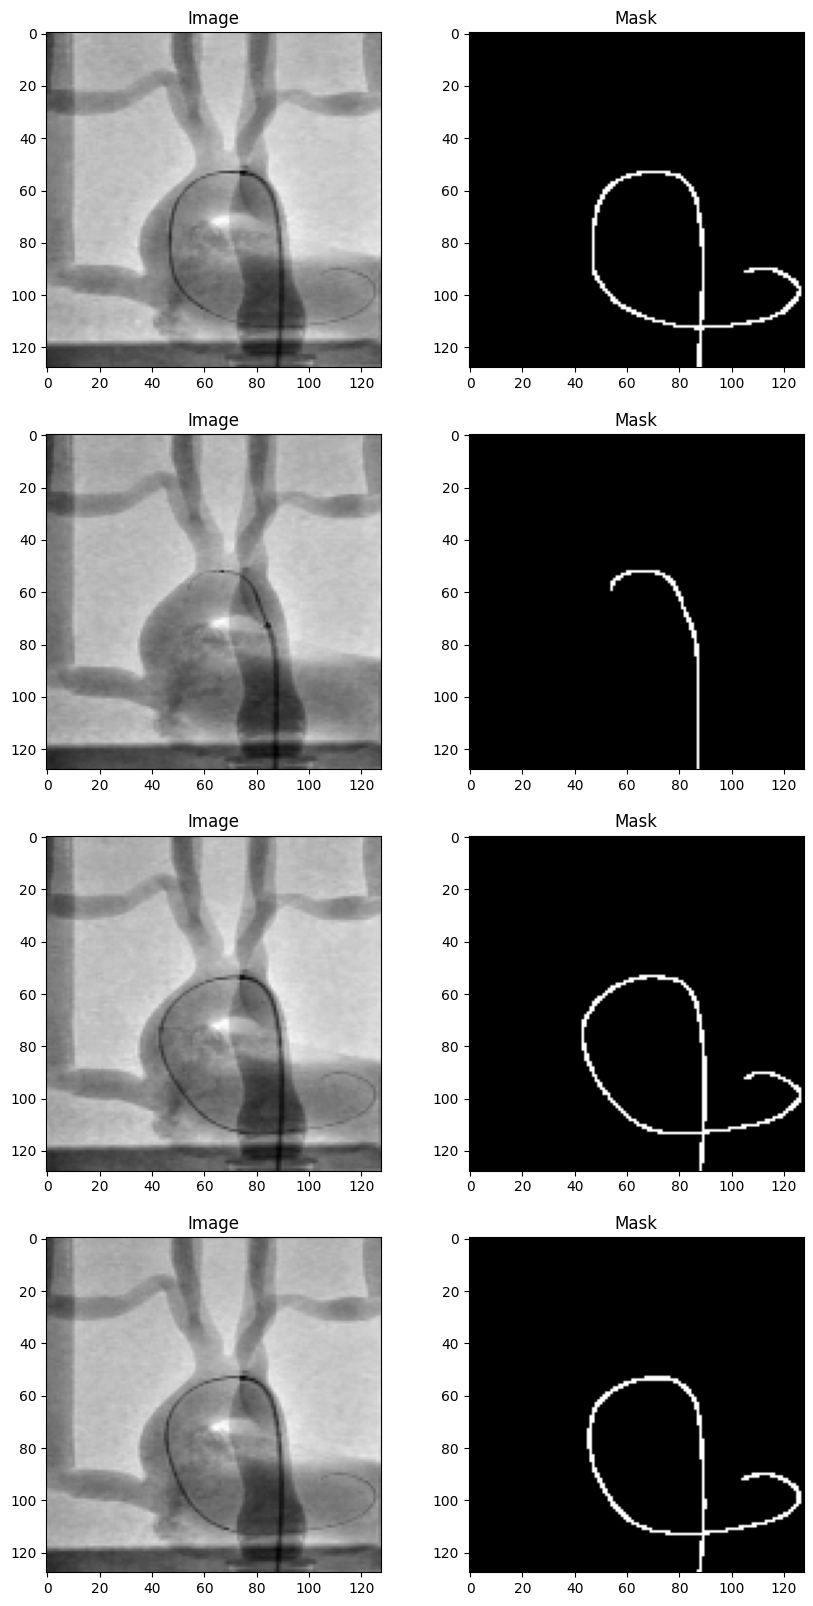

In [ ]:
import matplotlib.pyplot as plt

# Check the range of normalized images
print(f"Images - min: {train_dataset.images.min()}, max: {train_dataset.images.max()}, mean: {train_dataset.images.mean()}, std: {train_dataset.images.std()}")

# Visualize a few examples of images and masks
def visualize_samples(images, masks, num_samples=4):
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    for i in range(num_samples):
        axs[i, 0].imshow(images[i, 0], cmap='gray')
        axs[i, 0].set_title('Image')
        axs[i, 1].imshow(masks[i, 0], cmap='gray')
        axs[i, 1].set_title('Mask')
    plt.show()

# Visualize samples from the training dataset
visualize_samples(train_dataset.images, train_dataset.masks)


In [ ]:
# Define DSCNet model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kernel_size = 3
extend_scope = 1
if_offset = True
number = 64
dim = 1

dscnet = DSCNet(
    n_channels=1,  # Set number of input channels to 1
    n_classes=1,
    kernel_size=kernel_size,
    extend_scope=extend_scope,
    if_offset=if_offset,
    device=device,
    number=number,
    dim=dim
).to(device)

# Run a sample inference
for images, masks in train_loader:
    images = images.to(device)
    masks = masks.to(device)
    outputs = dscnet(images)
    print(outputs.shape)
    break


Mask 31 - min: 0.0, max: 1.0, mean: 0.01495361328125
Mask 19 - min: 0.0, max: 1.0, mean: 0.0147705078125
Mask 5 - min: 0.0, max: 1.0, mean: 0.023193359375
Mask 16 - min: 0.0, max: 1.0, mean: 0.00701904296875


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Block 0 Output: 0.37730109691619873, 0.0, 7.212783336639404
Block 1 Output: 0.38445141911506653, 0.0, 9.278295516967773
Block 2 Output: 0.3923657238483429, 0.0, 6.085167407989502
Block 3 Output: 0.39690878987312317, 0.0, 5.484476089477539
Block 4 Output: 0.39595454931259155, 0.0, 5.51627254486084
Block 5 Output: 0.39401084184646606, 0.0, 6.785637378692627
Block 6 Output: 0.3918464183807373, 0.0, 6.136068820953369
torch.Size([4, 1, 128, 128])


Loaded image from /content/drive/My Drive/phantom3/Phantom_Image_434_Fluoroscopy_Image_433.png with shape (128, 128, 4) and unique values: [  0   5   6  12  13  15  18  19  22  23  25  26  27  29  30  32  34  36
  38  40  43  44  47  48  50  51  52  54  55  56  58  59  60  62  64  65
  68  69  70  72  73  75  76  77  79  80  81  83  84  86  87  89  91  93
  94  96  97 100 101 102 104 105 107 108 109 111 112 113 115 116 118 119
 121 123 125 126 128 129 130 131 133 134 136 137 139 140 141 143 144 146
 147 150 151 153 154 155 157 158 160 161 162 163 165 166 168 169 171 172
 173 175 176 178 179 182 183 185 186 187 189 190 192 193 194 195 197 198
 200 201 203 204 205 207 208 210 211 214 215 217 218 219 221 222 224 225
 226 227 229 230 232 233 235 236 243 246 249 251 253 255]
Loaded image from /content/drive/My Drive/phantom3/Phantom_Image_435_Fluoroscopy_Image_434.png with shape (128, 128, 4) and unique values: [  2   6   9  12  13  15  16  18  19  20  22  23  25  26  27  29  30  32
  34  3

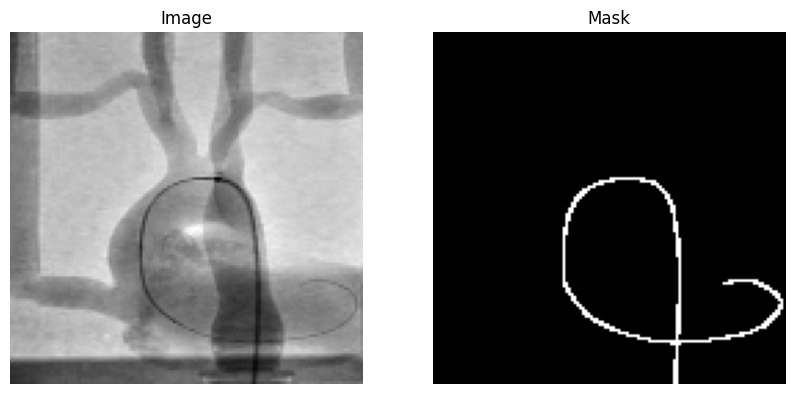

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize an image and its mask
def visualize_sample(image, mask):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(image[0], cmap='gray')
    axs[0].set_title('Image')
    axs[0].axis('off')

    axs[1].imshow(mask[0], cmap='gray')
    axs[1].set_title('Mask')
    axs[1].axis('off')

    plt.show()

# Load your dataset
image_folder_path = '/content/drive/My Drive/phantom3'
image_prefix = 'Fluoroscopy_Image'
mask_prefix = 'Annotation'
image_size = (128, 128)

dataset = Dataloader(image_folder_path, image_prefix, mask_prefix, image_size)

# Get a sample from the dataset
sample_image, sample_mask = dataset[0]  # Get the first sample

# Convert the tensors to numpy arrays for visualization
sample_image = sample_image.numpy()
sample_mask = sample_mask.numpy()

# Visualize the sample
visualize_sample(sample_image, sample_mask)


# **The ONE TO USE**

Loaded image from /content/drive/My Drive/phantom3/Phantom_Image_434_Fluoroscopy_Image_433.png with shape (128, 128, 4) and unique values: [  0   5   6  12  13  15  18  19  22  23  25  26  27  29  30  32  34  36
  38  40  43  44  47  48  50  51  52  54  55  56  58  59  60  62  64  65
  68  69  70  72  73  75  76  77  79  80  81  83  84  86  87  89  91  93
  94  96  97 100 101 102 104 105 107 108 109 111 112 113 115 116 118 119
 121 123 125 126 128 129 130 131 133 134 136 137 139 140 141 143 144 146
 147 150 151 153 154 155 157 158 160 161 162 163 165 166 168 169 171 172
 173 175 176 178 179 182 183 185 186 187 189 190 192 193 194 195 197 198
 200 201 203 204 205 207 208 210 211 214 215 217 218 219 221 222 224 225
 226 227 229 230 232 233 235 236 243 246 249 251 253 255]
Loaded image from /content/drive/My Drive/phantom3/Phantom_Image_435_Fluoroscopy_Image_434.png with shape (128, 128, 4) and unique values: [  2   6   9  12  13  15  16  18  19  20  22  23  25  26  27  29  30  32
  34  3

INFO:root:Start training!
[2024-07-27 08:34:29,982][<ipython-input-9-d121a4341015>] Start training!


Mask 10 - min: 0.0, max: 1.0, mean: 0.0068359375
Mask 1 - min: 0.0, max: 1.0, mean: 0.00830078125
Mask 29 - min: 0.0, max: 1.0, mean: 0.0140380859375
Mask 17 - min: 0.0, max: 1.0, mean: 0.01446533203125
Block 0 Output: 0.37533748149871826, 0.0, 8.063773155212402
Block 1 Output: 0.34716305136680603, 0.0, 7.473654747009277
Block 2 Output: 0.36464425921440125, 0.0, 7.081299304962158
Block 3 Output: 0.4315422773361206, 0.0, 4.222253322601318
Block 4 Output: 0.4234975576400757, 0.0, 5.860825538635254
Block 5 Output: 0.4007965326309204, 0.0, 4.607924938201904
Block 6 Output: 0.609400749206543, 0.0, 20.511844635009766
Mask 3 - min: 0.0, max: 1.0, mean: 0.02398681640625
Mask 4 - min: 0.0, max: 1.0, mean: 0.02337646484375
Mask 16 - min: 0.0, max: 1.0, mean: 0.00701904296875
Mask 6 - min: 0.0, max: 1.0, mean: 0.0242919921875
Block 0 Output: 0.376076340675354, 0.0, 9.820028305053711
Block 1 Output: 0.34709495306015015, 0.0, 7.3873209953308105
Block 2 Output: 0.36871784925460815, 0.0, 7.4343047142

INFO:root:Epoch: [1/25], Train Loss: 0.056192, Val Loss: 0.069006, Train IoU: 0.738169, Val IoU: 0.752569, Train Dice: 0.026197, Val Dice: 0.035672, Train RDice: 0.026197, Val RDice: 0.035672, Train clDice: 0.049078, Val clDice: 0.070595, Train AUC: 0.943012, Val AUC: 0.954306, Best Dice: 0.035672
[2024-07-27 08:35:32,998][<ipython-input-9-d121a4341015>] Epoch: [1/25], Train Loss: 0.056192, Val Loss: 0.069006, Train IoU: 0.738169, Val IoU: 0.752569, Train Dice: 0.026197, Val Dice: 0.035672, Train RDice: 0.026197, Val RDice: 0.035672, Train clDice: 0.049078, Val clDice: 0.070595, Train AUC: 0.943012, Val AUC: 0.954306, Best Dice: 0.035672


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
Mask 27 - min: 0.0, max: 1.0, mean: 0.0146484375
Mask 16 - min: 0.0, max: 1.0, mean: 0.00701904296875
Mask 4 - min: 0.0, max: 1.0, mean: 0.02337646484375
Mask 1 - min: 0.0, max: 1.0, mean: 0.00830078125
Block 0 Output: 0.3772585988044739, 0.0, 9.091623306274414
Block 1 Output: 0.3474901616573334, 0.0, 7.485102653503418
Block 2 Output: 0.34908056259155273, 0.0, 8.518163681030273
Block 3 Output: 0.4298778772354126, 0.0, 4.905232906341553
Block 4 Output: 0.4218728840351105, 0.0, 7.7702202796936035
Block 5 Output: 0.4023247957229614, 0.0, 4.437247276306152
Block 6 Output: 0.6132184267044067, 0.0, 27.604389190673828
Mask 3 - min: 0.0, max: 1.0, mean: 0.02398681640625
Mask 17 - min: 0.0, max: 1.0, mean: 0.01446533203125
Mask 25 - min: 0.0, max: 1.0, mean: 0.0147705078125
Mask 13 - min: 0.0, max: 1.0, mean: 0.00738525390625
Block 0 Output: 0.37627851963043213, 0.0, 9.198979377746582
Block 1 Output: 0.34893983602523804, 0.

INFO:root:Epoch: [2/25], Train Loss: 0.051776, Val Loss: 0.071038, Train IoU: 0.752902, Val IoU: 0.751076, Train Dice: 0.026278, Val Dice: 0.035548, Train RDice: 0.026278, Val RDice: 0.035548, Train clDice: 0.049955, Val clDice: 0.065803, Train AUC: 0.949470, Val AUC: 0.953366, Best Dice: 0.035672
[2024-07-27 08:36:19,383][<ipython-input-9-d121a4341015>] Epoch: [2/25], Train Loss: 0.051776, Val Loss: 0.071038, Train IoU: 0.752902, Val IoU: 0.751076, Train Dice: 0.026278, Val Dice: 0.035548, Train RDice: 0.026278, Val RDice: 0.035548, Train clDice: 0.049955, Val clDice: 0.065803, Train AUC: 0.949470, Val AUC: 0.953366, Best Dice: 0.035672


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
Mask 31 - min: 0.0, max: 1.0, mean: 0.01495361328125
Mask 8 - min: 0.0, max: 1.0, mean: 0.0245361328125
Mask 12 - min: 0.0, max: 1.0, mean: 0.007568359375
Mask 9 - min: 0.0, max: 1.0, mean: 0.0078125
Block 0 Output: 0.3768259584903717, 0.0, 8.843568801879883
Block 1 Output: 0.34834468364715576, 0.0, 7.036716938018799
Block 2 Output: 0.3574228882789612, 0.0, 8.029428482055664
Block 3 Output: 0.4314236342906952, 0.0, 4.52638578414917
Block 4 Output: 0.42276129126548767, 0.0, 6.9078779220581055
Block 5 Output: 0.4030407667160034, 0.0, 4.344023704528809
Block 6 Output: 0.6073113679885864, 0.0, 23.294824600219727
Mask 11 - min: 0.0, max: 1.0, mean: 0.00775146484375
Mask 22 - min: 0.0, max: 1.0, mean: 0.0146484375
Mask 25 - min: 0.0, max: 1.0, mean: 0.0147705078125
Mask 28 - min: 0.0, max: 1.0, mean: 0.014404296875
Block 0 Output: 0.3757023811340332, 0.0, 7.794809341430664
Block 1 Output: 0.3479529619216919, 0.0, 7.40248

INFO:root:Epoch: [3/25], Train Loss: 0.048717, Val Loss: 0.067639, Train IoU: 0.762682, Val IoU: 0.758816, Train Dice: 0.025518, Val Dice: 0.035430, Train RDice: 0.025518, Val RDice: 0.035430, Train clDice: 0.048342, Val clDice: 0.081490, Train AUC: 0.951328, Val AUC: 0.953328, Best Dice: 0.035672
[2024-07-27 08:37:04,588][<ipython-input-9-d121a4341015>] Epoch: [3/25], Train Loss: 0.048717, Val Loss: 0.067639, Train IoU: 0.762682, Val IoU: 0.758816, Train Dice: 0.025518, Val Dice: 0.035430, Train RDice: 0.025518, Val RDice: 0.035430, Train clDice: 0.048342, Val clDice: 0.081490, Train AUC: 0.951328, Val AUC: 0.953328, Best Dice: 0.035672


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
Mask 14 - min: 0.0, max: 1.0, mean: 0.00689697265625
Mask 23 - min: 0.0, max: 1.0, mean: 0.013916015625
Mask 17 - min: 0.0, max: 1.0, mean: 0.01446533203125
Mask 10 - min: 0.0, max: 1.0, mean: 0.0068359375
Block 0 Output: 0.376356840133667, 0.0, 8.669057846069336
Block 1 Output: 0.34890714287757874, 0.0, 6.829132556915283
Block 2 Output: 0.36937206983566284, 0.0, 7.287512302398682
Block 3 Output: 0.43128538131713867, 0.0, 4.442874908447266
Block 4 Output: 0.4230271577835083, 0.0, 6.250614166259766
Block 5 Output: 0.4081881046295166, 0.0, 4.414325714111328
Block 6 Output: 0.614020586013794, 0.0, 22.711605072021484
Mask 25 - min: 0.0, max: 1.0, mean: 0.0147705078125
Mask 29 - min: 0.0, max: 1.0, mean: 0.0140380859375
Mask 11 - min: 0.0, max: 1.0, mean: 0.00775146484375
Mask 3 - min: 0.0, max: 1.0, mean: 0.02398681640625
Block 0 Output: 0.3780573606491089, 0.0, 8.585221290588379
Block 1 Output: 0.3486204743385315, 0.0

INFO:root:Epoch: [4/25], Train Loss: 0.047861, Val Loss: 0.068883, Train IoU: 0.769612, Val IoU: 0.759856, Train Dice: 0.026184, Val Dice: 0.035551, Train RDice: 0.026184, Val RDice: 0.035551, Train clDice: 0.054642, Val clDice: 0.093982, Train AUC: 0.952267, Val AUC: 0.964613, Best Dice: 0.035672
[2024-07-27 08:37:50,937][<ipython-input-9-d121a4341015>] Epoch: [4/25], Train Loss: 0.047861, Val Loss: 0.068883, Train IoU: 0.769612, Val IoU: 0.759856, Train Dice: 0.026184, Val Dice: 0.035551, Train RDice: 0.026184, Val RDice: 0.035551, Train clDice: 0.054642, Val clDice: 0.093982, Train AUC: 0.952267, Val AUC: 0.964613, Best Dice: 0.035672


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
Mask 31 - min: 0.0, max: 1.0, mean: 0.01495361328125
Mask 28 - min: 0.0, max: 1.0, mean: 0.014404296875
Mask 25 - min: 0.0, max: 1.0, mean: 0.0147705078125
Mask 12 - min: 0.0, max: 1.0, mean: 0.007568359375
Block 0 Output: 0.3765469193458557, 0.0, 8.74229621887207
Block 1 Output: 0.3484656512737274, 0.0, 6.58475399017334
Block 2 Output: 0.3728412687778473, 0.0, 8.062697410583496
Block 3 Output: 0.4296830892562866, 0.0, 4.6150336265563965
Block 4 Output: 0.42343926429748535, 0.0, 6.42147970199585
Block 5 Output: 0.4064292013645172, 0.0, 4.4677815437316895
Block 6 Output: 0.6197545528411865, 0.0, 17.75226402282715
Mask 3 - min: 0.0, max: 1.0, mean: 0.02398681640625
Mask 26 - min: 0.0, max: 1.0, mean: 0.0145263671875
Mask 15 - min: 0.0, max: 1.0, mean: 0.01336669921875
Mask 10 - min: 0.0, max: 1.0, mean: 0.0068359375
Block 0 Output: 0.37581706047058105, 0.0, 9.531682968139648
Block 1 Output: 0.3491973280906677, 0.0, 7

INFO:root:Epoch: [5/25], Train Loss: 0.049135, Val Loss: 0.067754, Train IoU: 0.766863, Val IoU: 0.762366, Train Dice: 0.026943, Val Dice: 0.035385, Train RDice: 0.026943, Val RDice: 0.035385, Train clDice: 0.060018, Val clDice: 0.069566, Train AUC: 0.957649, Val AUC: 0.954649, Best Dice: 0.035672
[2024-07-27 08:38:36,808][<ipython-input-9-d121a4341015>] Epoch: [5/25], Train Loss: 0.049135, Val Loss: 0.067754, Train IoU: 0.766863, Val IoU: 0.762366, Train Dice: 0.026943, Val Dice: 0.035385, Train RDice: 0.026943, Val RDice: 0.035385, Train clDice: 0.060018, Val clDice: 0.069566, Train AUC: 0.957649, Val AUC: 0.954649, Best Dice: 0.035672


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
Mask 4 - min: 0.0, max: 1.0, mean: 0.02337646484375
Mask 9 - min: 0.0, max: 1.0, mean: 0.0078125
Mask 15 - min: 0.0, max: 1.0, mean: 0.01336669921875
Mask 22 - min: 0.0, max: 1.0, mean: 0.0146484375
Block 0 Output: 0.3754923939704895, 0.0, 10.65999698638916
Block 1 Output: 0.34776800870895386, 0.0, 7.20442533493042
Block 2 Output: 0.3714723587036133, 0.0, 6.479887008666992
Block 3 Output: 0.43328139185905457, 0.0, 3.9762966632843018
Block 4 Output: 0.4241029918193817, 0.0, 5.861295223236084
Block 5 Output: 0.4041815996170044, 0.0, 4.909937858581543
Block 6 Output: 0.6123514175415039, 0.0, 21.117347717285156
Mask 16 - min: 0.0, max: 1.0, mean: 0.00701904296875
Mask 11 - min: 0.0, max: 1.0, mean: 0.00775146484375
Mask 26 - min: 0.0, max: 1.0, mean: 0.0145263671875
Mask 21 - min: 0.0, max: 1.0, mean: 0.00543212890625
Block 0 Output: 0.37484508752822876, 0.0, 7.8803205490112305
Block 1 Output: 0.3487442433834076, 0.0, 

INFO:root:Epoch: [6/25], Train Loss: 0.046596, Val Loss: 0.068618, Train IoU: 0.775474, Val IoU: 0.756031, Train Dice: 0.025698, Val Dice: 0.035426, Train RDice: 0.025698, Val RDice: 0.035426, Train clDice: 0.047942, Val clDice: 0.067901, Train AUC: 0.948851, Val AUC: 0.950404, Best Dice: 0.035672
[2024-07-27 08:39:23,621][<ipython-input-9-d121a4341015>] Epoch: [6/25], Train Loss: 0.046596, Val Loss: 0.068618, Train IoU: 0.775474, Val IoU: 0.756031, Train Dice: 0.025698, Val Dice: 0.035426, Train RDice: 0.025698, Val RDice: 0.035426, Train clDice: 0.047942, Val clDice: 0.067901, Train AUC: 0.948851, Val AUC: 0.950404, Best Dice: 0.035672


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
Mask 29 - min: 0.0, max: 1.0, mean: 0.0140380859375
Mask 26 - min: 0.0, max: 1.0, mean: 0.0145263671875
Mask 15 - min: 0.0, max: 1.0, mean: 0.01336669921875
Mask 1 - min: 0.0, max: 1.0, mean: 0.00830078125
Block 0 Output: 0.376729279756546, 0.0, 7.719029426574707
Block 1 Output: 0.3464130461215973, 0.0, 6.799202919006348
Block 2 Output: 0.36681294441223145, 0.0, 6.75590181350708
Block 3 Output: 0.432513564825058, 0.0, 3.9803011417388916
Block 4 Output: 0.4244900345802307, 0.0, 5.759695529937744
Block 5 Output: 0.40396931767463684, 0.0, 4.991202354431152
Block 6 Output: 0.6130905151367188, 0.0, 20.08592414855957
Mask 21 - min: 0.0, max: 1.0, mean: 0.00543212890625
Mask 8 - min: 0.0, max: 1.0, mean: 0.0245361328125
Mask 9 - min: 0.0, max: 1.0, mean: 0.0078125
Mask 0 - min: 0.0, max: 1.0, mean: 0.022705078125
Block 0 Output: 0.3736424744129181, 0.0, 9.14692211151123
Block 1 Output: 0.3476725220680237, 0.0, 6.746310234

INFO:root:Epoch: [7/25], Train Loss: 0.049508, Val Loss: 0.066823, Train IoU: 0.767771, Val IoU: 0.763157, Train Dice: 0.026263, Val Dice: 0.035521, Train RDice: 0.026263, Val RDice: 0.035521, Train clDice: 0.050522, Val clDice: 0.082143, Train AUC: 0.951908, Val AUC: 0.953862, Best Dice: 0.035672
[2024-07-27 08:40:09,426][<ipython-input-9-d121a4341015>] Epoch: [7/25], Train Loss: 0.049508, Val Loss: 0.066823, Train IoU: 0.767771, Val IoU: 0.763157, Train Dice: 0.026263, Val Dice: 0.035521, Train RDice: 0.026263, Val RDice: 0.035521, Train clDice: 0.050522, Val clDice: 0.082143, Train AUC: 0.951908, Val AUC: 0.953862, Best Dice: 0.035672


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
Mask 27 - min: 0.0, max: 1.0, mean: 0.0146484375
Mask 6 - min: 0.0, max: 1.0, mean: 0.0242919921875
Mask 9 - min: 0.0, max: 1.0, mean: 0.0078125
Mask 15 - min: 0.0, max: 1.0, mean: 0.01336669921875
Block 0 Output: 0.37693119049072266, 0.0, 7.777019500732422
Block 1 Output: 0.3470695912837982, 0.0, 6.809739589691162
Block 2 Output: 0.36658647656440735, 0.0, 6.98967981338501
Block 3 Output: 0.43212205171585083, 0.0, 3.97656512260437
Block 4 Output: 0.4237041175365448, 0.0, 5.670984268188477
Block 5 Output: 0.40702003240585327, 0.0, 4.685523509979248
Block 6 Output: 0.6138726472854614, 0.0, 19.311655044555664
Mask 12 - min: 0.0, max: 1.0, mean: 0.007568359375
Mask 29 - min: 0.0, max: 1.0, mean: 0.0140380859375
Mask 28 - min: 0.0, max: 1.0, mean: 0.014404296875
Mask 22 - min: 0.0, max: 1.0, mean: 0.0146484375
Block 0 Output: 0.3743519186973572, 0.0, 7.920092582702637
Block 1 Output: 0.34804415702819824, 0.0, 6.92550611

INFO:root:Epoch: [8/25], Train Loss: 0.048511, Val Loss: 0.068040, Train IoU: 0.760205, Val IoU: 0.759775, Train Dice: 0.025220, Val Dice: 0.035467, Train RDice: 0.025220, Val RDice: 0.035467, Train clDice: 0.050224, Val clDice: 0.069020, Train AUC: 0.959303, Val AUC: 0.952065, Best Dice: 0.035672
[2024-07-27 08:40:55,343][<ipython-input-9-d121a4341015>] Epoch: [8/25], Train Loss: 0.048511, Val Loss: 0.068040, Train IoU: 0.760205, Val IoU: 0.759775, Train Dice: 0.025220, Val Dice: 0.035467, Train RDice: 0.025220, Val RDice: 0.035467, Train clDice: 0.050224, Val clDice: 0.069020, Train AUC: 0.959303, Val AUC: 0.952065, Best Dice: 0.035672


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
Mask 6 - min: 0.0, max: 1.0, mean: 0.0242919921875
Mask 29 - min: 0.0, max: 1.0, mean: 0.0140380859375
Mask 28 - min: 0.0, max: 1.0, mean: 0.014404296875
Mask 12 - min: 0.0, max: 1.0, mean: 0.007568359375
Block 0 Output: 0.376160591840744, 0.0, 9.034992218017578
Block 1 Output: 0.34827783703804016, 0.0, 6.657051086425781
Block 2 Output: 0.36287179589271545, 0.0, 7.630910396575928
Block 3 Output: 0.42988157272338867, 0.0, 4.257345199584961
Block 4 Output: 0.42251279950141907, 0.0, 5.767513751983643
Block 5 Output: 0.40583547949790955, 0.0, 4.88102912902832
Block 6 Output: 0.6132568717002869, 0.0, 17.416025161743164
Mask 15 - min: 0.0, max: 1.0, mean: 0.01336669921875
Mask 8 - min: 0.0, max: 1.0, mean: 0.0245361328125
Mask 20 - min: 0.0, max: 1.0, mean: 0.013916015625
Mask 17 - min: 0.0, max: 1.0, mean: 0.01446533203125
Block 0 Output: 0.37458527088165283, 0.0, 8.964725494384766
Block 1 Output: 0.3489812910556793, 0.

INFO:root:Epoch: [9/25], Train Loss: 0.047297, Val Loss: 0.067884, Train IoU: 0.762485, Val IoU: 0.764560, Train Dice: 0.025631, Val Dice: 0.035344, Train RDice: 0.025631, Val RDice: 0.035344, Train clDice: 0.047034, Val clDice: 0.066477, Train AUC: 0.938948, Val AUC: 0.953961, Best Dice: 0.035672
[2024-07-27 08:41:40,726][<ipython-input-9-d121a4341015>] Epoch: [9/25], Train Loss: 0.047297, Val Loss: 0.067884, Train IoU: 0.762485, Val IoU: 0.764560, Train Dice: 0.025631, Val Dice: 0.035344, Train RDice: 0.025631, Val RDice: 0.035344, Train clDice: 0.047034, Val clDice: 0.066477, Train AUC: 0.938948, Val AUC: 0.953961, Best Dice: 0.035672


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
Mask 13 - min: 0.0, max: 1.0, mean: 0.00738525390625
Mask 22 - min: 0.0, max: 1.0, mean: 0.0146484375
Mask 4 - min: 0.0, max: 1.0, mean: 0.02337646484375
Mask 31 - min: 0.0, max: 1.0, mean: 0.01495361328125
Block 0 Output: 0.37500524520874023, 0.0, 9.371520042419434
Block 1 Output: 0.34939754009246826, 0.0, 6.48376989364624
Block 2 Output: 0.3620937466621399, 0.0, 7.381728172302246
Block 3 Output: 0.4284246265888214, 0.0, 4.416310787200928
Block 4 Output: 0.42293715476989746, 0.0, 5.96230411529541
Block 5 Output: 0.4050218164920807, 0.0, 4.96026611328125
Block 6 Output: 0.6070156097412109, 0.0, 19.390478134155273
Mask 9 - min: 0.0, max: 1.0, mean: 0.0078125
Mask 28 - min: 0.0, max: 1.0, mean: 0.014404296875
Mask 27 - min: 0.0, max: 1.0, mean: 0.0146484375
Mask 8 - min: 0.0, max: 1.0, mean: 0.0245361328125
Block 0 Output: 0.37753093242645264, 0.0, 8.570255279541016
Block 1 Output: 0.34875738620758057, 0.0, 6.5995316

INFO:root:Epoch: [10/25], Train Loss: 0.047652, Val Loss: 0.068807, Train IoU: 0.764755, Val IoU: 0.760387, Train Dice: 0.026254, Val Dice: 0.035551, Train RDice: 0.026254, Val RDice: 0.035551, Train clDice: 0.050681, Val clDice: 0.070112, Train AUC: 0.952770, Val AUC: 0.957733, Best Dice: 0.035672
[2024-07-27 08:42:26,423][<ipython-input-9-d121a4341015>] Epoch: [10/25], Train Loss: 0.047652, Val Loss: 0.068807, Train IoU: 0.764755, Val IoU: 0.760387, Train Dice: 0.026254, Val Dice: 0.035551, Train RDice: 0.026254, Val RDice: 0.035551, Train clDice: 0.050681, Val clDice: 0.070112, Train AUC: 0.952770, Val AUC: 0.957733, Best Dice: 0.035672


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
Mask 13 - min: 0.0, max: 1.0, mean: 0.00738525390625
Mask 23 - min: 0.0, max: 1.0, mean: 0.013916015625
Mask 14 - min: 0.0, max: 1.0, mean: 0.00689697265625
Mask 31 - min: 0.0, max: 1.0, mean: 0.01495361328125
Block 0 Output: 0.37596940994262695, 0.0, 8.495121955871582
Block 1 Output: 0.3491780757904053, 0.0, 6.7779035568237305
Block 2 Output: 0.36573702096939087, 0.0, 7.333002090454102
Block 3 Output: 0.4280853867530823, 0.0, 4.593170642852783
Block 4 Output: 0.4235658645629883, 0.0, 5.981832981109619
Block 5 Output: 0.40544289350509644, 0.0, 4.783905029296875
Block 6 Output: 0.6189976930618286, 0.0, 24.45585060119629
Mask 10 - min: 0.0, max: 1.0, mean: 0.0068359375
Mask 0 - min: 0.0, max: 1.0, mean: 0.022705078125
Mask 15 - min: 0.0, max: 1.0, mean: 0.01336669921875
Mask 28 - min: 0.0, max: 1.0, mean: 0.014404296875
Block 0 Output: 0.3758457601070404, 0.0, 9.155826568603516
Block 1 Output: 0.3491661846637726, 0.0

INFO:root:Epoch: [11/25], Train Loss: 0.051837, Val Loss: 0.068195, Train IoU: 0.762917, Val IoU: 0.762558, Train Dice: 0.027403, Val Dice: 0.035485, Train RDice: 0.027403, Val RDice: 0.035485, Train clDice: 0.050807, Val clDice: 0.064823, Train AUC: 0.944940, Val AUC: 0.955806, Best Dice: 0.035672
[2024-07-27 08:43:13,034][<ipython-input-9-d121a4341015>] Epoch: [11/25], Train Loss: 0.051837, Val Loss: 0.068195, Train IoU: 0.762917, Val IoU: 0.762558, Train Dice: 0.027403, Val Dice: 0.035485, Train RDice: 0.027403, Val RDice: 0.035485, Train clDice: 0.050807, Val clDice: 0.064823, Train AUC: 0.944940, Val AUC: 0.955806, Best Dice: 0.035672


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
Mask 15 - min: 0.0, max: 1.0, mean: 0.01336669921875
Mask 13 - min: 0.0, max: 1.0, mean: 0.00738525390625
Mask 11 - min: 0.0, max: 1.0, mean: 0.00775146484375
Mask 3 - min: 0.0, max: 1.0, mean: 0.02398681640625
Block 0 Output: 0.376130074262619, 0.0, 8.786858558654785
Block 1 Output: 0.3493378758430481, 0.0, 7.003455638885498
Block 2 Output: 0.37048110365867615, 0.0, 7.893509864807129
Block 3 Output: 0.4291417896747589, 0.0, 4.631150245666504
Block 4 Output: 0.4233468174934387, 0.0, 5.990993976593018
Block 5 Output: 0.40590018033981323, 0.0, 4.441247940063477
Block 6 Output: 0.6103249788284302, 0.0, 23.118675231933594
Mask 22 - min: 0.0, max: 1.0, mean: 0.0146484375
Mask 27 - min: 0.0, max: 1.0, mean: 0.0146484375
Mask 23 - min: 0.0, max: 1.0, mean: 0.013916015625
Mask 28 - min: 0.0, max: 1.0, mean: 0.014404296875
Block 0 Output: 0.375663697719574, 0.0, 8.599365234375
Block 1 Output: 0.348970890045166, 0.0, 6.98581

INFO:root:Epoch: [12/25], Train Loss: 0.046383, Val Loss: 0.068330, Train IoU: 0.771118, Val IoU: 0.757015, Train Dice: 0.025539, Val Dice: 0.035439, Train RDice: 0.025539, Val RDice: 0.035439, Train clDice: 0.047312, Val clDice: 0.068083, Train AUC: 0.954550, Val AUC: 0.953540, Best Dice: 0.035672
[2024-07-27 08:43:59,373][<ipython-input-9-d121a4341015>] Epoch: [12/25], Train Loss: 0.046383, Val Loss: 0.068330, Train IoU: 0.771118, Val IoU: 0.757015, Train Dice: 0.025539, Val Dice: 0.035439, Train RDice: 0.025539, Val RDice: 0.035439, Train clDice: 0.047312, Val clDice: 0.068083, Train AUC: 0.954550, Val AUC: 0.953540, Best Dice: 0.035672


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
Mask 29 - min: 0.0, max: 1.0, mean: 0.0140380859375
Mask 8 - min: 0.0, max: 1.0, mean: 0.0245361328125
Mask 26 - min: 0.0, max: 1.0, mean: 0.0145263671875
Mask 23 - min: 0.0, max: 1.0, mean: 0.013916015625
Block 0 Output: 0.3776594400405884, 0.0, 8.275496482849121
Block 1 Output: 0.3473164141178131, 0.0, 6.797435760498047
Block 2 Output: 0.3678448498249054, 0.0, 6.977676868438721
Block 3 Output: 0.4298939108848572, 0.0, 4.315920829772949
Block 4 Output: 0.4234636723995209, 0.0, 6.042250633239746
Block 5 Output: 0.4013884663581848, 0.0, 4.549411773681641
Block 6 Output: 0.6128566265106201, 0.0, 21.74631690979004
Mask 1 - min: 0.0, max: 1.0, mean: 0.00830078125
Mask 12 - min: 0.0, max: 1.0, mean: 0.007568359375
Mask 27 - min: 0.0, max: 1.0, mean: 0.0146484375
Mask 18 - min: 0.0, max: 1.0, mean: 0.0050048828125
Block 0 Output: 0.3750736117362976, 0.0, 7.5225958824157715
Block 1 Output: 0.349192351102829, 0.0, 6.788084

INFO:root:Epoch: [13/25], Train Loss: 0.047708, Val Loss: 0.069247, Train IoU: 0.767335, Val IoU: 0.757386, Train Dice: 0.025725, Val Dice: 0.035320, Train RDice: 0.025725, Val RDice: 0.035320, Train clDice: 0.047909, Val clDice: 0.065252, Train AUC: 0.950592, Val AUC: 0.950197, Best Dice: 0.035672
[2024-07-27 08:44:46,017][<ipython-input-9-d121a4341015>] Epoch: [13/25], Train Loss: 0.047708, Val Loss: 0.069247, Train IoU: 0.767335, Val IoU: 0.757386, Train Dice: 0.025725, Val Dice: 0.035320, Train RDice: 0.025725, Val RDice: 0.035320, Train clDice: 0.047909, Val clDice: 0.065252, Train AUC: 0.950592, Val AUC: 0.950197, Best Dice: 0.035672


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
Mask 0 - min: 0.0, max: 1.0, mean: 0.022705078125
Mask 18 - min: 0.0, max: 1.0, mean: 0.0050048828125
Mask 20 - min: 0.0, max: 1.0, mean: 0.013916015625
Mask 23 - min: 0.0, max: 1.0, mean: 0.013916015625
Block 0 Output: 0.3767967224121094, 0.0, 10.680761337280273
Block 1 Output: 0.34806060791015625, 0.0, 7.3032050132751465
Block 2 Output: 0.3697676658630371, 0.0, 7.4473066329956055
Block 3 Output: 0.4306120276451111, 0.0, 4.203067779541016
Block 4 Output: 0.42211613059043884, 0.0, 6.016702175140381
Block 5 Output: 0.4009777903556824, 0.0, 4.756587982177734
Block 6 Output: 0.6096238493919373, 0.0, 27.101232528686523
Mask 1 - min: 0.0, max: 1.0, mean: 0.00830078125
Mask 17 - min: 0.0, max: 1.0, mean: 0.01446533203125
Mask 3 - min: 0.0, max: 1.0, mean: 0.02398681640625
Mask 27 - min: 0.0, max: 1.0, mean: 0.0146484375
Block 0 Output: 0.3751302659511566, 0.0, 9.132798194885254
Block 1 Output: 0.34885892271995544, 0.0, 6

INFO:root:Epoch: [14/25], Train Loss: 0.047889, Val Loss: 0.068739, Train IoU: 0.765968, Val IoU: 0.761815, Train Dice: 0.025598, Val Dice: 0.035420, Train RDice: 0.025598, Val RDice: 0.035420, Train clDice: 0.046327, Val clDice: 0.063183, Train AUC: 0.946451, Val AUC: 0.956019, Best Dice: 0.035672
[2024-07-27 08:45:32,325][<ipython-input-9-d121a4341015>] Epoch: [14/25], Train Loss: 0.047889, Val Loss: 0.068739, Train IoU: 0.765968, Val IoU: 0.761815, Train Dice: 0.025598, Val Dice: 0.035420, Train RDice: 0.025598, Val RDice: 0.035420, Train clDice: 0.046327, Val clDice: 0.063183, Train AUC: 0.946451, Val AUC: 0.956019, Best Dice: 0.035672


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
Mask 22 - min: 0.0, max: 1.0, mean: 0.0146484375
Mask 16 - min: 0.0, max: 1.0, mean: 0.00701904296875
Mask 8 - min: 0.0, max: 1.0, mean: 0.0245361328125
Mask 6 - min: 0.0, max: 1.0, mean: 0.0242919921875
Block 0 Output: 0.3747851252555847, 0.0, 8.469682693481445
Block 1 Output: 0.3487056791782379, 0.0, 6.880842685699463
Block 2 Output: 0.3702754080295563, 0.0, 7.7638959884643555
Block 3 Output: 0.42767488956451416, 0.0, 4.507811069488525
Block 4 Output: 0.4205380082130432, 0.0, 6.053893089294434
Block 5 Output: 0.40035557746887207, 0.0, 4.893493175506592
Block 6 Output: 0.6063158512115479, 0.0, 25.734638214111328
Mask 21 - min: 0.0, max: 1.0, mean: 0.00543212890625
Mask 25 - min: 0.0, max: 1.0, mean: 0.0147705078125
Mask 0 - min: 0.0, max: 1.0, mean: 0.022705078125
Mask 14 - min: 0.0, max: 1.0, mean: 0.00689697265625
Block 0 Output: 0.37441039085388184, 0.0, 9.116331100463867
Block 1 Output: 0.34898310899734497, 0.

INFO:root:Epoch: [15/25], Train Loss: 0.047465, Val Loss: 0.067702, Train IoU: 0.766442, Val IoU: 0.763837, Train Dice: 0.025759, Val Dice: 0.035549, Train RDice: 0.025759, Val RDice: 0.035549, Train clDice: 0.047790, Val clDice: 0.066844, Train AUC: 0.950858, Val AUC: 0.958328, Best Dice: 0.035672
[2024-07-27 08:46:19,858][<ipython-input-9-d121a4341015>] Epoch: [15/25], Train Loss: 0.047465, Val Loss: 0.067702, Train IoU: 0.766442, Val IoU: 0.763837, Train Dice: 0.025759, Val Dice: 0.035549, Train RDice: 0.025759, Val RDice: 0.035549, Train clDice: 0.047790, Val clDice: 0.066844, Train AUC: 0.950858, Val AUC: 0.958328, Best Dice: 0.035672


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
Mask 6 - min: 0.0, max: 1.0, mean: 0.0242919921875
Mask 17 - min: 0.0, max: 1.0, mean: 0.01446533203125
Mask 16 - min: 0.0, max: 1.0, mean: 0.00701904296875
Mask 14 - min: 0.0, max: 1.0, mean: 0.00689697265625
Block 0 Output: 0.37641966342926025, 0.0, 9.163318634033203
Block 1 Output: 0.34850454330444336, 0.0, 6.986063480377197
Block 2 Output: 0.3614126145839691, 0.0, 7.537034034729004
Block 3 Output: 0.4285092353820801, 0.0, 4.256891250610352
Block 4 Output: 0.42026200890541077, 0.0, 5.764770030975342
Block 5 Output: 0.4018545150756836, 0.0, 4.980952262878418
Block 6 Output: 0.6156456470489502, 0.0, 23.098186492919922
Mask 8 - min: 0.0, max: 1.0, mean: 0.0245361328125
Mask 20 - min: 0.0, max: 1.0, mean: 0.013916015625
Mask 27 - min: 0.0, max: 1.0, mean: 0.0146484375
Mask 11 - min: 0.0, max: 1.0, mean: 0.00775146484375
Block 0 Output: 0.3754083216190338, 0.0, 9.675538063049316
Block 1 Output: 0.3486819267272949, 0.

INFO:root:Epoch: [16/25], Train Loss: 0.049194, Val Loss: 0.068306, Train IoU: 0.775693, Val IoU: 0.766571, Train Dice: 0.026927, Val Dice: 0.035492, Train RDice: 0.026927, Val RDice: 0.035492, Train clDice: 0.048944, Val clDice: 0.062906, Train AUC: 0.953577, Val AUC: 0.961532, Best Dice: 0.035672
[2024-07-27 08:47:06,435][<ipython-input-9-d121a4341015>] Epoch: [16/25], Train Loss: 0.049194, Val Loss: 0.068306, Train IoU: 0.775693, Val IoU: 0.766571, Train Dice: 0.026927, Val Dice: 0.035492, Train RDice: 0.026927, Val RDice: 0.035492, Train clDice: 0.048944, Val clDice: 0.062906, Train AUC: 0.953577, Val AUC: 0.961532, Best Dice: 0.035672


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
Mask 12 - min: 0.0, max: 1.0, mean: 0.007568359375
Mask 11 - min: 0.0, max: 1.0, mean: 0.00775146484375
Mask 8 - min: 0.0, max: 1.0, mean: 0.0245361328125
Mask 29 - min: 0.0, max: 1.0, mean: 0.0140380859375
Block 0 Output: 0.3751721978187561, 0.0, 8.294160842895508
Block 1 Output: 0.34919974207878113, 0.0, 6.9809370040893555
Block 2 Output: 0.3664626181125641, 0.0, 7.544908046722412
Block 3 Output: 0.4290335774421692, 0.0, 4.521999359130859
Block 4 Output: 0.42085400223731995, 0.0, 5.96503210067749
Block 5 Output: 0.4031735062599182, 0.0, 4.642134189605713
Block 6 Output: 0.6055291295051575, 0.0, 18.925567626953125
Mask 22 - min: 0.0, max: 1.0, mean: 0.0146484375
Mask 31 - min: 0.0, max: 1.0, mean: 0.01495361328125
Mask 13 - min: 0.0, max: 1.0, mean: 0.00738525390625
Mask 21 - min: 0.0, max: 1.0, mean: 0.00543212890625
Block 0 Output: 0.37546634674072266, 0.0, 8.438342094421387
Block 1 Output: 0.34918999671936035, 

INFO:root:Epoch: [17/25], Train Loss: 0.050122, Val Loss: 0.067505, Train IoU: 0.762115, Val IoU: 0.755184, Train Dice: 0.026091, Val Dice: 0.035340, Train RDice: 0.026091, Val RDice: 0.035340, Train clDice: 0.048496, Val clDice: 0.067322, Train AUC: 0.944989, Val AUC: 0.950219, Best Dice: 0.035672
[2024-07-27 08:47:53,093][<ipython-input-9-d121a4341015>] Epoch: [17/25], Train Loss: 0.050122, Val Loss: 0.067505, Train IoU: 0.762115, Val IoU: 0.755184, Train Dice: 0.026091, Val Dice: 0.035340, Train RDice: 0.026091, Val RDice: 0.035340, Train clDice: 0.048496, Val clDice: 0.067322, Train AUC: 0.944989, Val AUC: 0.950219, Best Dice: 0.035672


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
Mask 6 - min: 0.0, max: 1.0, mean: 0.0242919921875
Mask 20 - min: 0.0, max: 1.0, mean: 0.013916015625
Mask 15 - min: 0.0, max: 1.0, mean: 0.01336669921875
Mask 26 - min: 0.0, max: 1.0, mean: 0.0145263671875
Block 0 Output: 0.3765827417373657, 0.0, 8.519103050231934
Block 1 Output: 0.3483320474624634, 0.0, 7.09112548828125
Block 2 Output: 0.36892497539520264, 0.0, 7.191601753234863
Block 3 Output: 0.4298988878726959, 0.0, 4.371698379516602
Block 4 Output: 0.420846551656723, 0.0, 5.989330768585205
Block 5 Output: 0.40304791927337646, 0.0, 4.512880802154541
Block 6 Output: 0.6203944683074951, 0.0, 23.081422805786133
Mask 17 - min: 0.0, max: 1.0, mean: 0.01446533203125
Mask 16 - min: 0.0, max: 1.0, mean: 0.00701904296875
Mask 10 - min: 0.0, max: 1.0, mean: 0.0068359375
Mask 18 - min: 0.0, max: 1.0, mean: 0.0050048828125
Block 0 Output: 0.3766934871673584, 0.0, 7.857753276824951
Block 1 Output: 0.3482266366481781, 0.0, 

INFO:root:Epoch: [18/25], Train Loss: 0.048898, Val Loss: 0.070485, Train IoU: 0.763472, Val IoU: 0.741250, Train Dice: 0.026242, Val Dice: 0.035236, Train RDice: 0.026242, Val RDice: 0.035236, Train clDice: 0.049971, Val clDice: 0.076885, Train AUC: 0.953630, Val AUC: 0.938933, Best Dice: 0.035672
[2024-07-27 08:48:40,588][<ipython-input-9-d121a4341015>] Epoch: [18/25], Train Loss: 0.048898, Val Loss: 0.070485, Train IoU: 0.763472, Val IoU: 0.741250, Train Dice: 0.026242, Val Dice: 0.035236, Train RDice: 0.026242, Val RDice: 0.035236, Train clDice: 0.049971, Val clDice: 0.076885, Train AUC: 0.953630, Val AUC: 0.938933, Best Dice: 0.035672


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
Mask 31 - min: 0.0, max: 1.0, mean: 0.01495361328125
Mask 8 - min: 0.0, max: 1.0, mean: 0.0245361328125
Mask 26 - min: 0.0, max: 1.0, mean: 0.0145263671875
Mask 25 - min: 0.0, max: 1.0, mean: 0.0147705078125
Block 0 Output: 0.3772450387477875, 0.0, 8.535026550292969
Block 1 Output: 0.34738922119140625, 0.0, 6.658539772033691
Block 2 Output: 0.37210431694984436, 0.0, 7.823800086975098
Block 3 Output: 0.4289485812187195, 0.0, 4.610520362854004
Block 4 Output: 0.4203689694404602, 0.0, 6.076181888580322
Block 5 Output: 0.4013286530971527, 0.0, 4.395262241363525
Block 6 Output: 0.6137386560440063, 0.0, 18.523670196533203
Mask 9 - min: 0.0, max: 1.0, mean: 0.0078125
Mask 10 - min: 0.0, max: 1.0, mean: 0.0068359375
Mask 23 - min: 0.0, max: 1.0, mean: 0.013916015625
Mask 15 - min: 0.0, max: 1.0, mean: 0.01336669921875
Block 0 Output: 0.37787944078445435, 0.0, 7.637111663818359
Block 1 Output: 0.34750378131866455, 0.0, 6.80

INFO:root:Epoch: [19/25], Train Loss: 0.052470, Val Loss: 0.067707, Train IoU: 0.743730, Val IoU: 0.760442, Train Dice: 0.025370, Val Dice: 0.035558, Train RDice: 0.025370, Val RDice: 0.035558, Train clDice: 0.046652, Val clDice: 0.066874, Train AUC: 0.940205, Val AUC: 0.959215, Best Dice: 0.035672
[2024-07-27 08:49:26,688][<ipython-input-9-d121a4341015>] Epoch: [19/25], Train Loss: 0.052470, Val Loss: 0.067707, Train IoU: 0.743730, Val IoU: 0.760442, Train Dice: 0.025370, Val Dice: 0.035558, Train RDice: 0.025370, Val RDice: 0.035558, Train clDice: 0.046652, Val clDice: 0.066874, Train AUC: 0.940205, Val AUC: 0.959215, Best Dice: 0.035672


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
Mask 10 - min: 0.0, max: 1.0, mean: 0.0068359375
Mask 23 - min: 0.0, max: 1.0, mean: 0.013916015625
Mask 17 - min: 0.0, max: 1.0, mean: 0.01446533203125
Mask 26 - min: 0.0, max: 1.0, mean: 0.0145263671875
Block 0 Output: 0.3753756284713745, 0.0, 7.735164642333984
Block 1 Output: 0.3489258289337158, 0.0, 6.830240726470947
Block 2 Output: 0.3632853329181671, 0.0, 7.307775497436523
Block 3 Output: 0.4287111163139343, 0.0, 4.409733772277832
Block 4 Output: 0.41910305619239807, 0.0, 5.855128288269043
Block 5 Output: 0.39675217866897583, 0.0, 4.334380149841309
Block 6 Output: 0.6116236448287964, 0.0, 25.153358459472656
Mask 27 - min: 0.0, max: 1.0, mean: 0.0146484375
Mask 21 - min: 0.0, max: 1.0, mean: 0.00543212890625
Mask 18 - min: 0.0, max: 1.0, mean: 0.0050048828125
Mask 11 - min: 0.0, max: 1.0, mean: 0.00775146484375
Block 0 Output: 0.3775051236152649, 0.0, 8.0874605178833
Block 1 Output: 0.3475784659385681, 0.0, 6.

INFO:root:Epoch: [20/25], Train Loss: 0.052595, Val Loss: 0.072035, Train IoU: 0.751379, Val IoU: 0.753525, Train Dice: 0.026317, Val Dice: 0.035701, Train RDice: 0.026317, Val RDice: 0.035701, Train clDice: 0.052269, Val clDice: 0.070129, Train AUC: 0.953358, Val AUC: 0.968851, Best Dice: 0.035701
[2024-07-27 08:50:13,278][<ipython-input-9-d121a4341015>] Epoch: [20/25], Train Loss: 0.052595, Val Loss: 0.072035, Train IoU: 0.751379, Val IoU: 0.753525, Train Dice: 0.026317, Val Dice: 0.035701, Train RDice: 0.026317, Val RDice: 0.035701, Train clDice: 0.052269, Val clDice: 0.070129, Train AUC: 0.953358, Val AUC: 0.968851, Best Dice: 0.035701


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
Mask 13 - min: 0.0, max: 1.0, mean: 0.00738525390625
Mask 20 - min: 0.0, max: 1.0, mean: 0.013916015625
Mask 3 - min: 0.0, max: 1.0, mean: 0.02398681640625
Mask 22 - min: 0.0, max: 1.0, mean: 0.0146484375
Block 0 Output: 0.37559258937835693, 0.0, 8.113449096679688
Block 1 Output: 0.34907329082489014, 0.0, 6.6458740234375
Block 2 Output: 0.3599749207496643, 0.0, 7.0708746910095215
Block 3 Output: 0.4300404191017151, 0.0, 4.165324687957764
Block 4 Output: 0.4205147922039032, 0.0, 5.698339462280273
Block 5 Output: 0.3973168134689331, 0.0, 4.466770648956299
Block 6 Output: 0.615181565284729, 0.0, 26.746707916259766
Mask 6 - min: 0.0, max: 1.0, mean: 0.0242919921875
Mask 23 - min: 0.0, max: 1.0, mean: 0.013916015625
Mask 17 - min: 0.0, max: 1.0, mean: 0.01446533203125
Mask 16 - min: 0.0, max: 1.0, mean: 0.00701904296875
Block 0 Output: 0.3764342665672302, 0.0, 8.859918594360352
Block 1 Output: 0.34864774346351624, 0.0, 

INFO:root:Epoch: [21/25], Train Loss: 0.048438, Val Loss: 0.068508, Train IoU: 0.754794, Val IoU: 0.751601, Train Dice: 0.024937, Val Dice: 0.035333, Train RDice: 0.024937, Val RDice: 0.035333, Train clDice: 0.046673, Val clDice: 0.063334, Train AUC: 0.955251, Val AUC: 0.940314, Best Dice: 0.035701
[2024-07-27 08:51:00,027][<ipython-input-9-d121a4341015>] Epoch: [21/25], Train Loss: 0.048438, Val Loss: 0.068508, Train IoU: 0.754794, Val IoU: 0.751601, Train Dice: 0.024937, Val Dice: 0.035333, Train RDice: 0.024937, Val RDice: 0.035333, Train clDice: 0.046673, Val clDice: 0.063334, Train AUC: 0.955251, Val AUC: 0.940314, Best Dice: 0.035701


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
Mask 18 - min: 0.0, max: 1.0, mean: 0.0050048828125
Mask 20 - min: 0.0, max: 1.0, mean: 0.013916015625
Mask 26 - min: 0.0, max: 1.0, mean: 0.0145263671875
Mask 15 - min: 0.0, max: 1.0, mean: 0.01336669921875
Block 0 Output: 0.37415173649787903, 0.0, 8.037386894226074
Block 1 Output: 0.3482653498649597, 0.0, 6.677478313446045
Block 2 Output: 0.36090603470802307, 0.0, 7.285634517669678
Block 3 Output: 0.4288659393787384, 0.0, 4.345442771911621
Block 4 Output: 0.41979193687438965, 0.0, 5.932148456573486
Block 5 Output: 0.4004281163215637, 0.0, 4.629277229309082
Block 6 Output: 0.6204404830932617, 0.0, 25.55637550354004
Mask 17 - min: 0.0, max: 1.0, mean: 0.01446533203125
Mask 23 - min: 0.0, max: 1.0, mean: 0.013916015625
Mask 14 - min: 0.0, max: 1.0, mean: 0.00689697265625
Mask 10 - min: 0.0, max: 1.0, mean: 0.0068359375
Block 0 Output: 0.37590503692626953, 0.0, 7.844119071960449
Block 1 Output: 0.34767407178878784, 0

INFO:root:Epoch: [22/25], Train Loss: 0.048209, Val Loss: 0.068946, Train IoU: 0.761553, Val IoU: 0.760820, Train Dice: 0.025679, Val Dice: 0.035389, Train RDice: 0.025679, Val RDice: 0.035389, Train clDice: 0.046147, Val clDice: 0.063997, Train AUC: 0.946564, Val AUC: 0.957668, Best Dice: 0.035701
[2024-07-27 08:51:46,022][<ipython-input-9-d121a4341015>] Epoch: [22/25], Train Loss: 0.048209, Val Loss: 0.068946, Train IoU: 0.761553, Val IoU: 0.760820, Train Dice: 0.025679, Val Dice: 0.035389, Train RDice: 0.025679, Val RDice: 0.035389, Train clDice: 0.046147, Val clDice: 0.063997, Train AUC: 0.946564, Val AUC: 0.957668, Best Dice: 0.035701


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
Mask 22 - min: 0.0, max: 1.0, mean: 0.0146484375
Mask 27 - min: 0.0, max: 1.0, mean: 0.0146484375
Mask 13 - min: 0.0, max: 1.0, mean: 0.00738525390625
Mask 29 - min: 0.0, max: 1.0, mean: 0.0140380859375
Block 0 Output: 0.3747662305831909, 0.0, 8.490633964538574
Block 1 Output: 0.3483036160469055, 0.0, 7.049098014831543
Block 2 Output: 0.36111196875572205, 0.0, 7.615048408508301
Block 3 Output: 0.4289584755897522, 0.0, 4.3287835121154785
Block 4 Output: 0.4224565327167511, 0.0, 6.015681743621826
Block 5 Output: 0.39945462346076965, 0.0, 5.037899494171143
Block 6 Output: 0.6101891994476318, 0.0, 26.464994430541992
Mask 10 - min: 0.0, max: 1.0, mean: 0.0068359375
Mask 16 - min: 0.0, max: 1.0, mean: 0.00701904296875
Mask 17 - min: 0.0, max: 1.0, mean: 0.01446533203125
Mask 26 - min: 0.0, max: 1.0, mean: 0.0145263671875
Block 0 Output: 0.37501877546310425, 0.0, 8.213415145874023
Block 1 Output: 0.34841644763946533, 0.0,

INFO:root:Epoch: [23/25], Train Loss: 0.047243, Val Loss: 0.070166, Train IoU: 0.767654, Val IoU: 0.760598, Train Dice: 0.025667, Val Dice: 0.035438, Train RDice: 0.025667, Val RDice: 0.035438, Train clDice: 0.045704, Val clDice: 0.063631, Train AUC: 0.949318, Val AUC: 0.957517, Best Dice: 0.035701
[2024-07-27 08:52:32,303][<ipython-input-9-d121a4341015>] Epoch: [23/25], Train Loss: 0.047243, Val Loss: 0.070166, Train IoU: 0.767654, Val IoU: 0.760598, Train Dice: 0.025667, Val Dice: 0.035438, Train RDice: 0.025667, Val RDice: 0.035438, Train clDice: 0.045704, Val clDice: 0.063631, Train AUC: 0.949318, Val AUC: 0.957517, Best Dice: 0.035701


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
Mask 14 - min: 0.0, max: 1.0, mean: 0.00689697265625
Mask 3 - min: 0.0, max: 1.0, mean: 0.02398681640625
Mask 23 - min: 0.0, max: 1.0, mean: 0.013916015625
Mask 8 - min: 0.0, max: 1.0, mean: 0.0245361328125
Block 0 Output: 0.37652909755706787, 0.0, 8.520332336425781
Block 1 Output: 0.34880104660987854, 0.0, 7.027534484863281
Block 2 Output: 0.3655025064945221, 0.0, 7.539095878601074
Block 3 Output: 0.429180383682251, 0.0, 4.49269962310791
Block 4 Output: 0.42261767387390137, 0.0, 5.712930679321289
Block 5 Output: 0.40303945541381836, 0.0, 4.793941020965576
Block 6 Output: 0.6012817621231079, 0.0, 26.83269691467285
Mask 6 - min: 0.0, max: 1.0, mean: 0.0242919921875
Mask 17 - min: 0.0, max: 1.0, mean: 0.01446533203125
Mask 9 - min: 0.0, max: 1.0, mean: 0.0078125
Mask 27 - min: 0.0, max: 1.0, mean: 0.0146484375
Block 0 Output: 0.37650564312934875, 0.0, 9.12109088897705
Block 1 Output: 0.3484753370285034, 0.0, 6.609148

INFO:root:Epoch: [24/25], Train Loss: 0.050335, Val Loss: 0.069229, Train IoU: 0.765751, Val IoU: 0.756016, Train Dice: 0.026791, Val Dice: 0.035369, Train RDice: 0.026791, Val RDice: 0.035369, Train clDice: 0.047765, Val clDice: 0.059984, Train AUC: 0.951016, Val AUC: 0.949502, Best Dice: 0.035701
[2024-07-27 08:53:18,885][<ipython-input-9-d121a4341015>] Epoch: [24/25], Train Loss: 0.050335, Val Loss: 0.069229, Train IoU: 0.765751, Val IoU: 0.756016, Train Dice: 0.026791, Val Dice: 0.035369, Train RDice: 0.026791, Val RDice: 0.035369, Train clDice: 0.047765, Val clDice: 0.059984, Train AUC: 0.951016, Val AUC: 0.949502, Best Dice: 0.035701


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
Mask 10 - min: 0.0, max: 1.0, mean: 0.0068359375
Mask 23 - min: 0.0, max: 1.0, mean: 0.013916015625
Mask 20 - min: 0.0, max: 1.0, mean: 0.013916015625
Mask 16 - min: 0.0, max: 1.0, mean: 0.00701904296875
Block 0 Output: 0.3753289580345154, 0.0, 8.150755882263184
Block 1 Output: 0.34867432713508606, 0.0, 7.276250839233398
Block 2 Output: 0.36237138509750366, 0.0, 7.614875316619873
Block 3 Output: 0.42762550711631775, 0.0, 4.578588485717773
Block 4 Output: 0.42186492681503296, 0.0, 6.005014896392822
Block 5 Output: 0.402809202671051, 0.0, 4.925654411315918
Block 6 Output: 0.6158846616744995, 0.0, 28.425983428955078
Mask 13 - min: 0.0, max: 1.0, mean: 0.00738525390625
Mask 17 - min: 0.0, max: 1.0, mean: 0.01446533203125
Mask 26 - min: 0.0, max: 1.0, mean: 0.0145263671875
Mask 27 - min: 0.0, max: 1.0, mean: 0.0146484375
Block 0 Output: 0.3762305974960327, 0.0, 7.662196159362793
Block 1 Output: 0.34867504239082336, 0.0,

INFO:root:Epoch: [25/25], Train Loss: 0.048506, Val Loss: 0.065778, Train IoU: 0.777251, Val IoU: 0.761366, Train Dice: 0.026878, Val Dice: 0.035159, Train RDice: 0.026878, Val RDice: 0.035159, Train clDice: 0.044620, Val clDice: 0.059336, Train AUC: 0.948692, Val AUC: 0.938452, Best Dice: 0.035701
[2024-07-27 08:54:05,068][<ipython-input-9-d121a4341015>] Epoch: [25/25], Train Loss: 0.048506, Val Loss: 0.065778, Train IoU: 0.777251, Val IoU: 0.761366, Train Dice: 0.026878, Val Dice: 0.035159, Train RDice: 0.026878, Val RDice: 0.035159, Train clDice: 0.044620, Val clDice: 0.059336, Train AUC: 0.948692, Val AUC: 0.938452, Best Dice: 0.035701
INFO:root:Finish training!
[2024-07-27 08:54:05,071][<ipython-input-9-d121a4341015>] Finish training!


Model saved to /content/drive/My Drive/weights/dscnet_model_max.pth.pth
/content/drive/My Drive/weights/dscnet_model_max.pth
Predict and visualize training data
Mask 19 - min: 0.0, max: 1.0, mean: 0.0147705078125
Block 0 Output: 0.3748166263103485, 0.0, 7.841979026794434
Block 1 Output: 0.3495355546474457, 0.0, 6.449272632598877
Block 2 Output: 0.36086201667785645, 0.0, 7.484188556671143
Block 3 Output: 0.4294857978820801, 0.0, 4.2194390296936035
Block 4 Output: 0.4200435280799866, 0.0, 5.828216075897217
Block 5 Output: 0.39698129892349243, 0.0, 4.40347957611084
Block 6 Output: 0.6152393817901611, 0.0, 21.49803352355957
Prediction 0: Model output min 0.0, max 1.0, mean 0.01513671875
Prediction 0: Ground truth mask min 0.0, max 1.0, mean 0.0147705078125


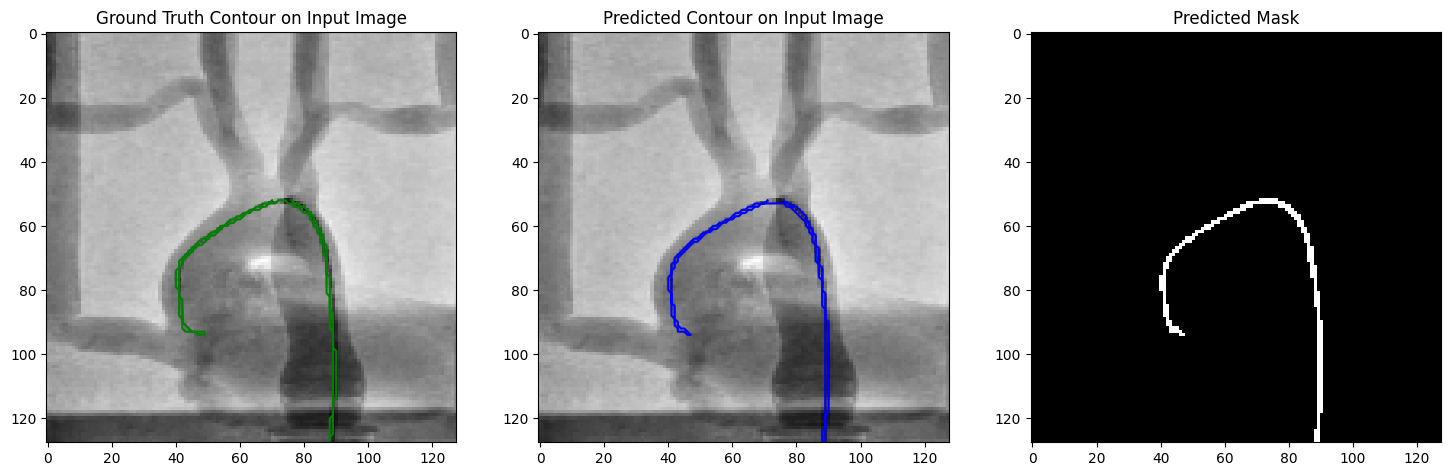

Mask 30 - min: 0.0, max: 1.0, mean: 0.014892578125
Block 0 Output: 0.3750639855861664, 0.0, 7.478461265563965
Block 1 Output: 0.34854310750961304, 0.0, 6.544360160827637
Block 2 Output: 0.3598391115665436, 0.0, 7.317894458770752
Block 3 Output: 0.4308185577392578, 0.0, 4.184478282928467
Block 4 Output: 0.42089566588401794, 0.0, 6.147597789764404
Block 5 Output: 0.3973042964935303, 0.0, 4.371760845184326
Block 6 Output: 0.610458254814148, 0.0, 17.002351760864258
Prediction 1: Model output min 0.0, max 1.0, mean 0.0157470703125
Prediction 1: Ground truth mask min 0.0, max 1.0, mean 0.014892578125


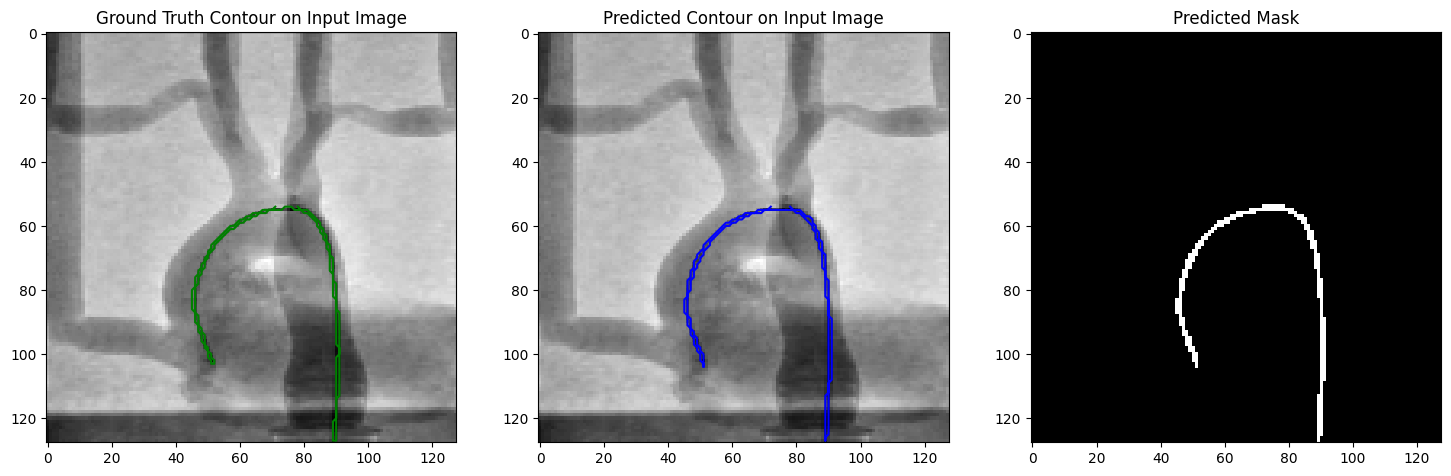

Mask 7 - min: 0.0, max: 1.0, mean: 0.02410888671875
Block 0 Output: 0.3749696612358093, 0.0, 7.912961483001709
Block 1 Output: 0.34887203574180603, 0.0, 6.416891098022461
Block 2 Output: 0.35869506001472473, 0.0, 7.634663105010986
Block 3 Output: 0.430223286151886, 0.0, 4.327694892883301
Block 4 Output: 0.41999325156211853, 0.0, 5.891482353210449
Block 5 Output: 0.3976527750492096, 0.0, 4.546196460723877
Block 6 Output: 0.609230101108551, 0.0, 17.311832427978516
Prediction 2: Model output min 0.0, max 1.0, mean 0.026611328125
Prediction 2: Ground truth mask min 0.0, max 1.0, mean 0.02410888671875


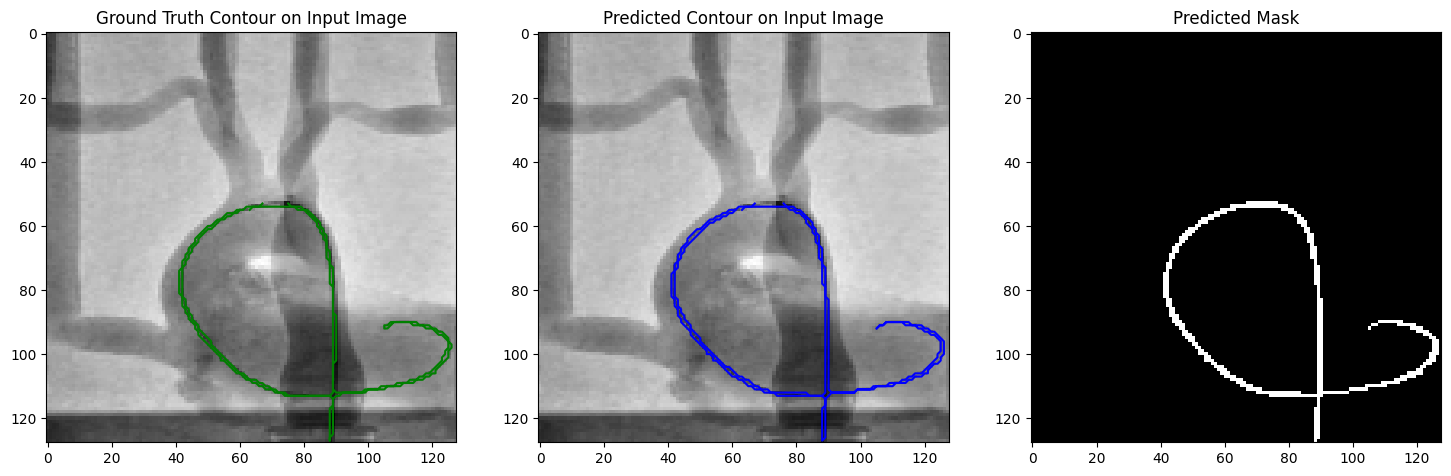

Mask 2 - min: 0.0, max: 1.0, mean: 0.02386474609375
Block 0 Output: 0.3767628073692322, 0.0, 7.88223934173584
Block 1 Output: 0.34873682260513306, 0.0, 6.432655334472656
Block 2 Output: 0.3589911162853241, 0.0, 7.863789081573486
Block 3 Output: 0.43073952198028564, 0.0, 4.534878730773926
Block 4 Output: 0.42027121782302856, 0.0, 6.0930280685424805
Block 5 Output: 0.3986913561820984, 0.0, 4.5359673500061035
Block 6 Output: 0.6104530692100525, 0.0, 16.512720108032227
Prediction 3: Model output min 0.0, max 1.0, mean 0.02618408203125
Prediction 3: Ground truth mask min 0.0, max 1.0, mean 0.02386474609375


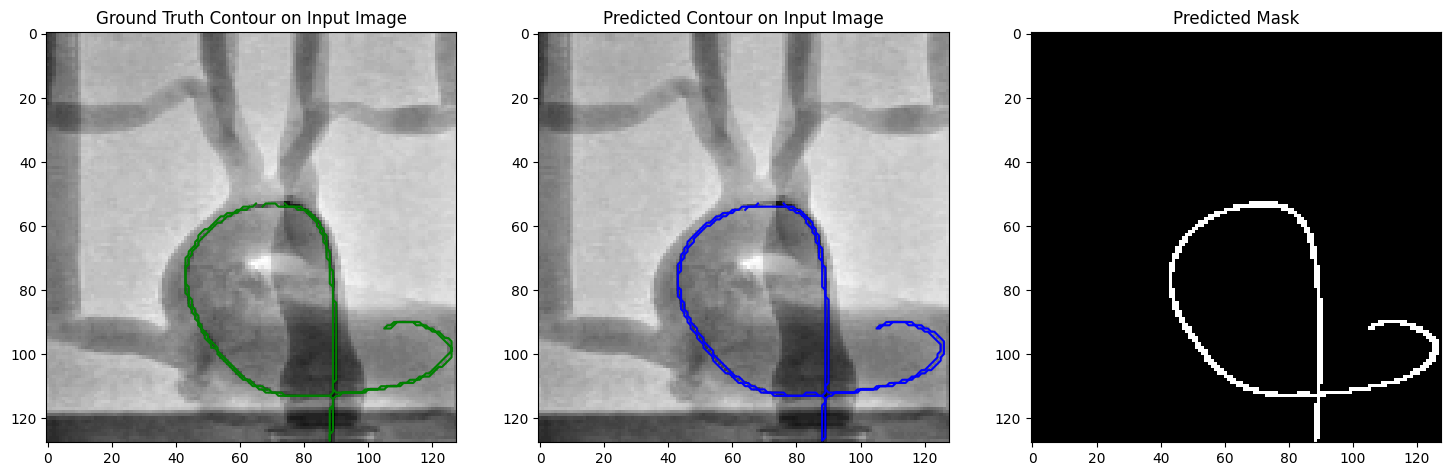

Mask 24 - min: 0.0, max: 1.0, mean: 0.0137939453125
Block 0 Output: 0.37540391087532043, 0.0, 7.785120487213135
Block 1 Output: 0.3481367528438568, 0.0, 6.656989097595215
Block 2 Output: 0.3588546812534332, 0.0, 7.996119499206543
Block 3 Output: 0.4286888539791107, 0.0, 4.373190402984619
Block 4 Output: 0.42009443044662476, 0.0, 5.945487976074219
Block 5 Output: 0.39770588278770447, 0.0, 4.474539279937744
Block 6 Output: 0.6140073537826538, 0.0, 27.949871063232422
Prediction 4: Model output min 0.0, max 1.0, mean 0.01416015625
Prediction 4: Ground truth mask min 0.0, max 1.0, mean 0.0137939453125


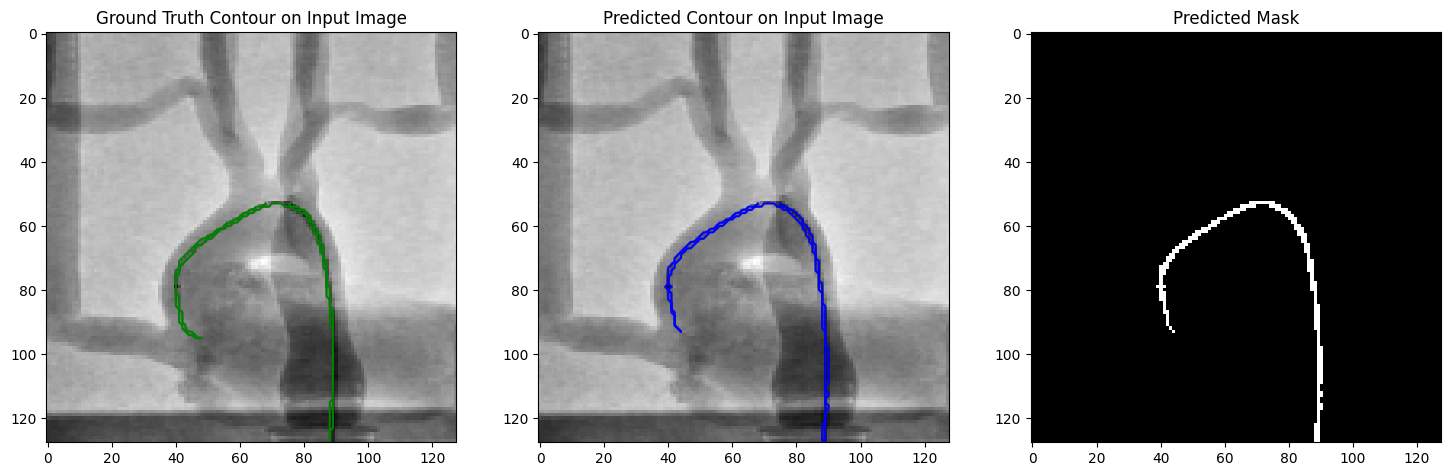

Mask 32 - min: 0.0, max: 1.0, mean: 0.013427734375
Block 0 Output: 0.37616419792175293, 0.0, 8.086440086364746
Block 1 Output: 0.3487342596054077, 0.0, 6.520402431488037
Block 2 Output: 0.3599852919578552, 0.0, 7.604834079742432
Block 3 Output: 0.42933017015457153, 0.0, 4.282642364501953
Block 4 Output: 0.42001378536224365, 0.0, 5.945736885070801
Block 5 Output: 0.3979642391204834, 0.0, 4.4730610847473145
Block 6 Output: 0.6148821115493774, 0.0, 19.594482421875
Prediction 5: Model output min 0.0, max 1.0, mean 0.01531982421875
Prediction 5: Ground truth mask min 0.0, max 1.0, mean 0.013427734375


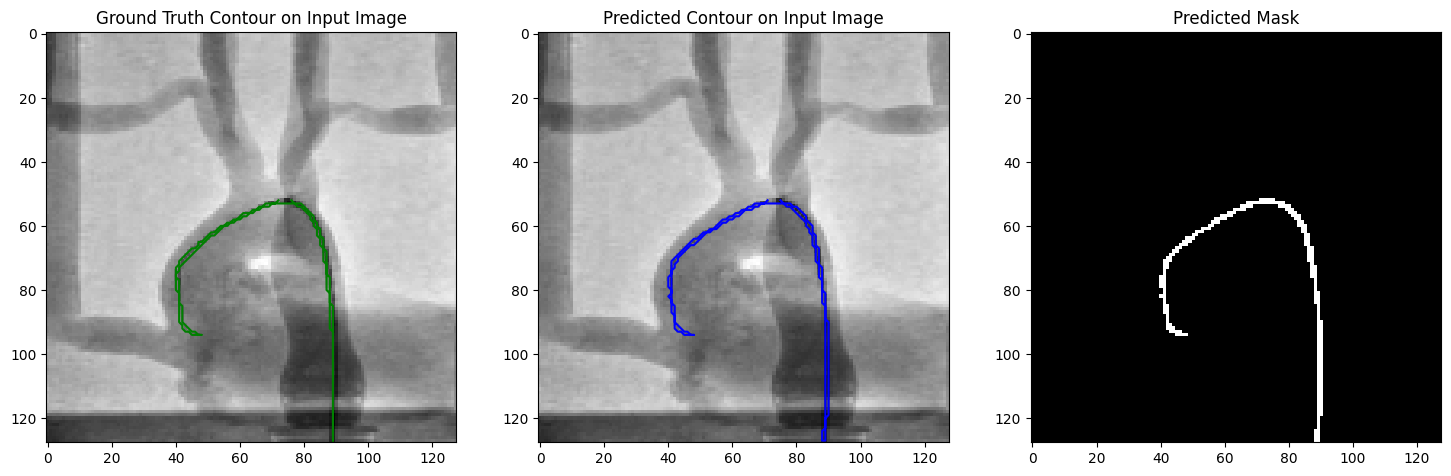

Mask 5 - min: 0.0, max: 1.0, mean: 0.023193359375
Block 0 Output: 0.37475061416625977, 0.0, 9.48909854888916
Block 1 Output: 0.34941619634628296, 0.0, 6.526943206787109
Block 2 Output: 0.3613267242908478, 0.0, 7.571743488311768
Block 3 Output: 0.4317312240600586, 0.0, 4.440649032592773
Block 4 Output: 0.42079275846481323, 0.0, 6.06636381149292
Block 5 Output: 0.39762642979621887, 0.0, 4.52540397644043
Block 6 Output: 0.6091018319129944, 0.0, 18.67318344116211
Prediction 6: Model output min 0.0, max 1.0, mean 0.02386474609375
Prediction 6: Ground truth mask min 0.0, max 1.0, mean 0.023193359375


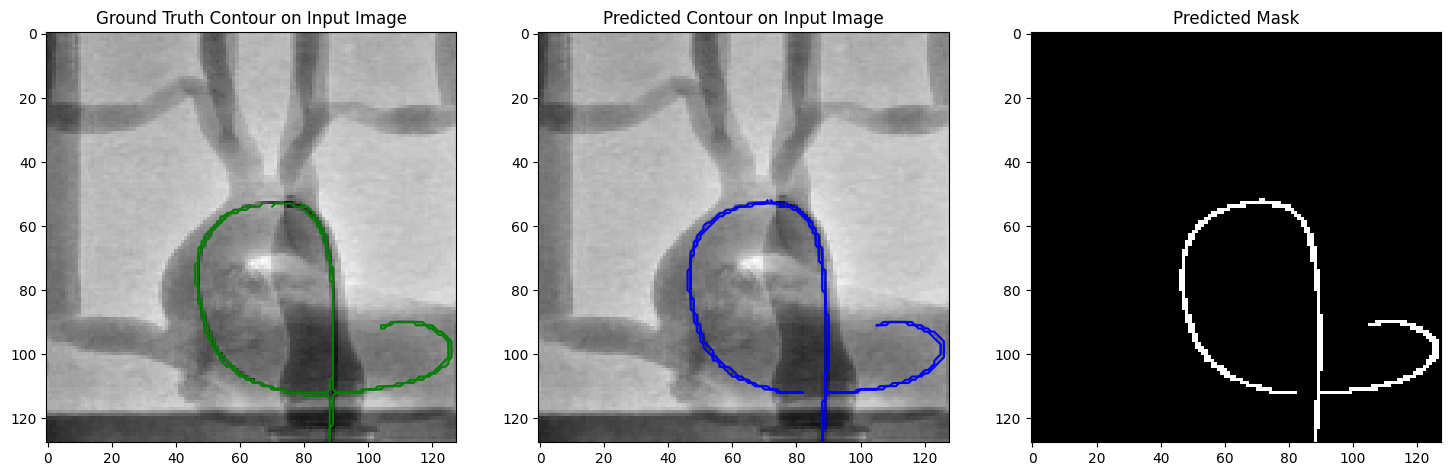

finish!
Mean IoU: 0.7575749499457223, Mean Dice: 0.8611233149256025, Mean RDice: 0.8611233149256025, Mean clDice: 0.8883275626223115, Mean AUC: 0.9437162827199483
nan


In [ ]:
import os
import torch
import logging
import numpy as np
from os.path import join
import SimpleITK as sitk
from datetime import datetime
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import warnings
import cv2
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
import random
import json
from scipy.ndimage import binary_dilation, generate_binary_structure
from scipy.ndimage import distance_transform_edt as distance
from sklearn.metrics import roc_auc_score

warnings.filterwarnings("ignore")

# AverageMeter to calculate the mean in the process
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class CrossEntropyLoss(nn.Module):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()

    def forward(self, y_true, y_pred):
        smooth = 1e-6
        return -torch.mean(y_true * torch.log(y_pred + smooth) +
                           (1 - y_true) * torch.log(1 - y_pred + smooth))

# Define metrics
def iou_score(output, target):
    smooth = 1e-6
    intersection = (output * target).sum()
    union = output.sum() + target.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

def dice_coefficient(output, target, smooth=1e-6):
    output = torch.sigmoid(output)
    output = output > 0.5
    output = output.float()

    intersection = (output * target).sum()
    dice = (2. * intersection + smooth) / (output.sum() + target.sum() + smooth)
    return dice.item()
def rdice_coefficient(output, target, smooth=1e-6):
    output = torch.sigmoid(output)
    output = output > 0.5
    output = output.float()

    target = target > 0.5
    target = target.float()

    intersection = (output * target).sum()
    target_sum = target.sum()

    # To avoid division by zero, add a small epsilon
    target_sum = target_sum + smooth

    # Calculate RDice
    rdice = (2. * intersection + smooth) / (output.sum() + target_sum + smooth)
    return rdice.item()


def cl_dice_coefficient(output, target, smooth=1e-6):
    def cl_score(mask1, mask2):
        S1 = (mask1 > 0.5).float()
        S2 = (mask2 > 0.5).float()

        S1_dt = torch.from_numpy(distance(S1.cpu().numpy())).to(S1.device)
        S2_dt = torch.from_numpy(distance(S2.cpu().numpy())).to(S2.device)

        cl_S = (S1 * S2_dt) + (S2 * S1_dt)
        cl_S = cl_S.sum()

        return 2 * cl_S / (S1.sum() + S2.sum() + smooth)

    output = torch.sigmoid(output)
    output = output.float()

    dice = dice_coefficient(output, target, smooth)
    cl_dice = cl_score(output, target)
    return (dice + cl_dice) / 2
def auc_score(output, target):
    output = torch.sigmoid(output)
    output = output.view(-1).detach().cpu().numpy()
    target = target.view(-1).detach().cpu().numpy()
    return roc_auc_score(target, output)

# Training epoch
def train_epoch(model, loader, optimizer, criterion, epoch, n_epochs):
    model.train()
    train_loss = 0
    train_iou = 0
    train_dice = 0
    train_rdice = 0
    train_cl_dice = 0
    train_auc = 0

    for batch_idx, (image, label) in enumerate(loader):
        if torch.cuda.is_available():
            image, label = image.cuda(), label.cuda()

        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_iou += iou_score(output, label)
        train_dice += dice_coefficient(output, label)
        train_rdice += rdice_coefficient(output, label)
        train_cl_dice += cl_dice_coefficient(output, label)
        train_auc += auc_score(output, label)

    train_loss /= len(loader)
    train_iou /= len(loader)
    train_dice /= len(loader)
    train_rdice /= len(loader)
    train_cl_dice /= len(loader)
    train_auc /= len(loader)

    print(f"Epoch: {epoch+1}/{n_epochs}, Train Loss: {train_loss:.6f}, Train IoU: {train_iou:.6f}, Train Dice: {train_dice:.6f}, Train RDice: {train_rdice:.6f}, Train clDice: {train_cl_dice:.6f}, Train AUC: {train_auc:.6f}")
    return train_loss, train_iou, train_dice, train_rdice, train_cl_dice, train_auc

# Validation epoch
def validate_epoch(model, loader, criterion):
    model.eval()
    val_loss = 0
    val_iou = 0
    val_dice = 0
    val_rdice = 0
    val_cl_dice = 0
    val_auc = 0

    with torch.no_grad():
        for image, label in loader:
            if torch.cuda.is_available():
                image, label = image.cuda(), label.cuda()

            output = model(image)
            loss = criterion(output, label)
            val_loss += loss.item()
            val_iou += iou_score(output, label)
            val_dice += dice_coefficient(output, label)
            val_rdice += rdice_coefficient(output, label)
            val_cl_dice += cl_dice_coefficient(output, label)
            val_auc += auc_score(output, label)

    val_loss /= len(loader)
    val_iou /= len(loader)
    val_dice /= len(loader)
    val_rdice /= len(loader)
    val_cl_dice /= len(loader)
    val_auc /= len(loader)

    print(f"Validation Loss: {val_loss:.6f}, Validation IoU: {val_iou:.6f}, Validation Dice: {val_dice:.6f}, Validation RDice: {val_rdice:.6f}, Validation clDice: {val_cl_dice:.6f}, Validation AUC: {val_auc:.6f}")
    return val_loss, val_iou, val_dice, val_rdice, val_cl_dice, val_auc

# Training loop
def Train_net(net, args, train_loader, val_loader):
    dice_m = 0

    if not args.if_retrain and os.path.exists(os.path.join(args.Dir_Weights, args.model_name)):
        net.load_state_dict(torch.load(os.path.join(args.Dir_Weights, args.model_name)))
        print(f"Loaded pre-trained weights from {os.path.join(args.Dir_Weights, args.model_name)}")
    else:
        print("Starting training from scratch...")

    if torch.cuda.is_available():
        net = net.cuda()

    optimizer = optim.AdamW(net.parameters(), lr=args.lr, betas=(0.9, 0.95))
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.8, patience=50)
    criterion = CrossEntropyLoss()

    dt = datetime.today()
    log_name = f"{dt.date()}_{dt.time().hour}:{dt.time().minute}:{dt.time().second}_{args.log_name}"
    logger = Get_logger(args.Dir_Log + log_name)
    logger.info("Start training!")

    for epoch in range(args.start_train_epoch, args.n_epochs):
        train_metrics = train_epoch(net, train_loader, optimizer, criterion, epoch, args.n_epochs)
        val_metrics = validate_epoch(net, val_loader, criterion)

        torch.save(net.state_dict(), os.path.join(args.Dir_Weights, args.model_name))

        val_dice = val_metrics[2]  # Assuming Dice is the third metric returned

        if val_dice > dice_m:
            dice_m = val_dice
            torch.save(net.state_dict(), os.path.join(args.Dir_Weights, args.model_name_max))
        # Save the model after every epoch
        save_model(net, optimizer, epoch, args.Dir_Weights, args.model_name_max)

        logger.info(f"Epoch: [{epoch+1}/{args.n_epochs}], "
                    f"Train Loss: {train_metrics[0]:.6f}, Val Loss: {val_metrics[0]:.6f}, "
                    f"Train IoU: {train_metrics[1]:.6f}, Val IoU: {val_metrics[1]:.6f}, "
                    f"Train Dice: {train_metrics[2]:.6f}, Val Dice: {val_metrics[2]:.6f}, "
                    f"Train RDice: {train_metrics[3]:.6f}, Val RDice: {val_metrics[3]:.6f}, "
                    f"Train clDice: {train_metrics[4]:.6f}, Val clDice: {val_metrics[4]:.6f}, "
                    f"Train AUC: {train_metrics[5]:.6f}, Val AUC: {val_metrics[5]:.6f}, "
                    f"Best Dice: {dice_m:.6f}")

    logger.info("Finish training!")

# Generate the log
def Get_logger(filename, verbosity=1, name=None):
    level_dict = {0: logging.DEBUG, 1: logging.INFO, 2: logging.WARNING}
    formatter = logging.Formatter("[%(asctime)s][%(filename)s] %(message)s")
    logger = logging.getLogger(name)
    logger.setLevel(level_dict[verbosity])

    fh = logging.FileHandler(filename, "w")
    fh.setFormatter(formatter)
    logger.addHandler(fh)

    sh = logging.StreamHandler()
    sh.setFormatter(formatter)
    logger.addHandler(sh)

    return logger

# Create required directories
def Create_files(args):
    directories = [
        args.save_path,
        args.save_path_max,
        args.Dir_Weights,
        args.Dir_Log,
    ]
    for directory in directories:
        if not os.path.exists(directory):
            os.makedirs(directory)

def save_model(model, optimizer, epoch, save_path, model_name):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(state, os.path.join(save_path, model_name + '.pth'))
    print(f"Model saved to {os.path.join(save_path, model_name + '.pth')}")

def reshape_img(image, y, x):
    out = np.zeros([y, x], dtype=np.float32)
    out[0:image.shape[0], 0:image.shape[1]] = image[0:image.shape[0], 0:image.shape[1]]
    return out

def Dice(label_dir, pred_dir):
    label_file = [f for f in os.listdir(label_dir) if f.startswith('Annotation')]
    file_num = len(label_file)
    dice = np.zeros(shape=(file_num), dtype=np.float32)
    i = 0

    for t in range(file_num):
        image_path = join(label_dir, label_file[t])
        name = label_file[t]

        predict = sitk.ReadImage(join(pred_dir, name))
        predict = sitk.GetArrayFromImage(predict)
        predict = predict.astype(np.float32)
        predict = np.where(predict > 0.5, 1, 0)

        groundtruth = sitk.ReadImage(image_path)
        groundtruth = sitk.GetArrayFromImage(groundtruth)
        groundtruth = groundtruth.astype(np.float32)
        groundtruth = groundtruth / (np.max(groundtruth))

        tmp = predict + groundtruth
        a = np.sum(np.where(tmp == 2, 1, 0))
        b = np.sum(predict)
        c = np.sum(groundtruth)

        dice[i] = (2 * a) / (b + c)
        print(name, dice[i])
        i += 1
    return dice

def extract_contours(mask):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# Predict and visualize process
def predict_and_visualize(model, dataset, save_path, args):
    print("Predict and visualize training data")
    model.eval()
    iou_scores = []
    dice_scores = []
    rdice_scores = []
    cl_dice_scores = []
    auc_scores = []

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    for t in range(len(dataset)):
        image, mask = dataset[t]
        image = image.numpy()[0]  # Assuming image shape is [1, H, W]
        mask = mask.numpy()[0]  # Assuming mask shape is [1, H, W]

        name = f"prediction_{t}.png"  # Creates a filename for the prediction output
        y, x = image.shape

        # Initialize prediction and normalization map
        ind = (max(y, x) // args.ROI_shape + 1) * args.ROI_shape
        predict = np.zeros([1, args.n_classes, y, x], dtype=np.float32)
        n_map = np.zeros([1, args.n_classes, y, x], dtype=np.float32)

        # Create the map kernel
        shape = (args.ROI_shape, args.ROI_shape)
        a = np.zeros(shape=shape)
        a = np.where(a == 0)
        map_kernal = 1 / ((a[0] - shape[0] // 2)**4 + (a[1] - shape[1] // 2)**4)
        map_kernal = np.reshape(map_kernal, newshape=(1, 1) + shape)

        image = image[np.newaxis, np.newaxis, :, :]
        stride_x = shape[0] // 2
        stride_y = shape[1] // 2

        # Process the image in overlapping patches
        for i in range((y - shape[0]) // stride_x + 1):
            for j in range((x - shape[1]) // stride_y + 1):
                image_i = image[:, :, i * stride_x:i * stride_x + shape[0],
                                j * stride_y:j * stride_y + shape[1]]
                image_i = torch.from_numpy(image_i)
                if torch.cuda.is_available():
                    image_i = image_i.cuda()
                output = model(image_i)
                output = output.data.cpu().numpy()

                predict[:, :, i * stride_x:i * stride_x + shape[0],
                        j * stride_y:j * stride_y + shape[1]] += (output * map_kernal)
                n_map[:, :, i * stride_x:i * stride_x + shape[0],
                      j * stride_y:j * stride_y + shape[1]] += map_kernal

        output = predict / n_map
        output = output.astype(dtype=np.float32)
        output_final = np.zeros([1, args.n_classes, y, x], dtype=np.float32)
        output_final[:, :, 0:y, 0:x] = output[:, :, 0:y, 0:x]

        # Binarize the predicted mask
        output_final[0][0] = (output_final[0][0] > 0.5).astype(np.uint8)

        # Debug output range
        print(f"Prediction {t}: Model output min {output_final[0][0].min()}, max {output_final[0][0].max()}, mean {output_final[0][0].mean()}")
        print(f"Prediction {t}: Ground truth mask min {mask.min()}, max {mask.max()}, mean {mask.mean()}")

        # Save prediction as .png
        plt.imsave(os.path.join(save_path, name), output_final[0][0], cmap='gray')

        # Check if masks are not empty
        if output_final[0][0].sum() == 0 or mask.sum() == 0:
            print(f"Empty mask detected for image {t}. Skipping IoU and Dice calculation.")
            continue

        # Calculate metrics
        iou = iou_score(torch.from_numpy(output_final[0][0]), torch.from_numpy(mask))
        dice = dice_coefficient(torch.from_numpy(output_final[0][0]), torch.from_numpy(mask))
        rdice = rdice_coefficient(torch.from_numpy(output_final[0][0]), torch.from_numpy(mask))
        cl_dice = cl_dice_coefficient(torch.from_numpy(output_final[0][0]), torch.from_numpy(mask))
        auc = auc_score(torch.from_numpy(output_final[0][0]), torch.from_numpy(mask))

        iou_scores.append(iou)
        dice_scores.append(dice)
        rdice_scores.append(rdice)
        cl_dice_scores.append(cl_dice)
        auc_scores.append(auc)

        # Extract contours
        ground_truth_contours = extract_contours(mask)
        predicted_contours = extract_contours(output_final[0][0])

        # Visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        axes[0].imshow(image[0][0], cmap='gray')
        for contour in ground_truth_contours:
            axes[0].plot(contour[:, 0, 0], contour[:, 0, 1], 'g')  # Ground truth in green
        axes[0].set_title('Ground Truth Contour on Input Image')

        axes[1].imshow(image[0][0], cmap='gray')
        for contour in predicted_contours:
            axes[1].plot(contour[:, 0, 0], contour[:, 0, 1], 'b')  # Predicted in blue
        axes[1].set_title('Predicted Contour on Input Image')

        axes[2].imshow(output_final[0][0], cmap='gray')
        axes[2].set_title('Predicted Mask')

        plt.show()

    print("finish!")
    mean_iou = np.mean(iou_scores)
    mean_dice = np.mean(dice_scores)
    mean_rdice = np.mean(rdice_scores)
    mean_cl_dice = np.mean(cl_dice_scores)
    mean_auc = np.mean(auc_scores)
    print(f"Mean IoU: {mean_iou}, Mean Dice: {mean_dice}, Mean RDice: {mean_rdice}, Mean clDice: {mean_cl_dice}, Mean AUC: {mean_auc}")

def Predict_Network(net, dataset, args):
    if torch.cuda.is_available():
        net = net.cuda()
    try:
        net.load_state_dict(
            torch.load(os.path.join(args.Dir_Weights, args.model_name_max)))
        print(os.path.join(args.Dir_Weights, args.model_name_max))
    except:
        print(
            "Warning 100: No parameters in weights_max, here use parameters in weights"
        )
        net.load_state_dict(
            torch.load(os.path.join(args.Dir_Weights, args.model_name)))
        print(os.path.join(args.Dir_Weights, args.model_name))
    predict_and_visualize(net, dataset, args.save_path_max, args)
    dice = Dice(args.image_folder_path, args.save_path_max)
    dice_mean = np.mean(dice)
    print(dice_mean)

def Train(args):
    os.environ["CUDA_VISIBLE_DEVICES"] = args.GPU_id
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    Create_files(args)  # Ensure required directories exist

    # Create dataset and split into training and validation sets
    dataset = Dataloader(args.image_folder_path, args.image_prefix, args.mask_prefix, args.image_size)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_data, val_data = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=args.batch_size, shuffle=False)

    pos_weight = dataset.calculate_class_weights()
    args.pos_weight = pos_weight

    if not args.if_onlytest:
        Train_net(net, args, train_loader, val_loader)
        Predict_Network(net, val_data, args)  # Pass validation data for prediction and visualization
    else:
        Predict_Network(net, val_data, args)  # Pass validation data for prediction and visualization

# Define the arguments class
class Args:
    def __init__(self):
        self.root_dir = '/content/drive/My Drive/'
        self.Dir_Weights = self.root_dir + 'weights/'
        self.Dir_Log = self.root_dir + 'logs/'
        self.save_path = self.root_dir + 'predictions/'
        self.save_path_max = self.root_dir + 'predictions_max/'
        self.model_name = 'dscnet_model.pth'
        self.model_name_max = 'dscnet_model_max.pth'
        self.image_folder_path = '/content/drive/My Drive/phantom3'
        self.image_prefix = 'Fluoroscopy_Image'
        self.mask_prefix = 'Annotation'
        self.image_size = (128, 128)
        self.batch_size = 4
        self.lr = 1e-4
        self.n_epochs = 25
        self.start_train_epoch = 0
        self.start_verify_epoch = 2
        self.log_name = 'training_log.txt'
        self.if_retrain = False
        self.if_onlytest = False
        self.n_channels = 1
        self.n_classes = 1
        self.kernel_size = 3
        self.extend_scope = 1
        self.if_offset = True
        self.n_basic_layer = 64
        self.dim = 1
        self.ROI_shape = 128
        self.GPU_id = '0'
        self.pos_weight = 1.0

args = Args()

net = DSCNet(
        n_channels=args.n_channels,
        n_classes=args.n_classes,
        kernel_size=args.kernel_size,
        extend_scope=args.extend_scope,
        if_offset=args.if_offset,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        number=args.n_basic_layer,
        dim=args.dim,
    )
Train(args)


In [ ]:
import os
import numpy as np
import SimpleITK as sitk
import torch
from torch.utils import data

# Function to resample images
def resample_image(image, new_size, interpolator=sitk.sitkLinear):
    original_size = image.GetSize()
    original_spacing = image.GetSpacing()
    new_spacing = [
        original_spacing[0] * (original_size[0] / new_size[0]),
        original_spacing[1] * (original_size[1] / new_size[1])
    ]

    resampled_image = sitk.Resample(
        image, new_size, sitk.Transform(), interpolator,
        image.GetOrigin(), new_spacing, image.GetDirection(), 0, image.GetPixelID()
    )
    return resampled_image

# Function to load images and masks
def load_images_and_masks(folder_paths, image_prefix='Fluoroscopy_Image', mask_prefix='Annotation', image_size=(128, 128)):
    images = []
    masks = []
    file_pairs = []

    for folder_path in folder_paths:
        for file_name in os.listdir(folder_path):
            if image_prefix in file_name:
                image_path = os.path.join(folder_path, file_name)
                corresponding_mask_name = file_name.replace(image_prefix, mask_prefix)
                mask_path = os.path.join(folder_path, corresponding_mask_name)

                if os.path.exists(mask_path):
                    image = sitk.ReadImage(image_path)
                    image = resample_image(image, image_size)
                    image = sitk.GetArrayFromImage(image)
                    images.append(image[..., 0])  # Use the first channel if multi-channel
                    file_pairs.append((image_path, mask_path))
                    print(f"Loaded image from {image_path} with shape {image.shape} and unique values: {np.unique(image)}")

    images = np.array(images).astype('float32') / 255.0

    masks = []
    for _, mask_path in file_pairs:
        mask = sitk.ReadImage(mask_path)
        mask = resample_image(mask, image_size, interpolator=sitk.sitkNearestNeighbor)
        mask = sitk.GetArrayFromImage(mask)
        mask = mask[..., 0]  # Use only the first channel
        masks.append(mask)
        print(f"Loaded mask from {mask_path} with shape {mask.shape} and unique values: {np.unique(mask)}")  # Debug statement

    masks = np.array(masks).astype('float32') / 255.0

    # Ensure masks are binary
    masks = (masks > 0).astype(np.float32)

    return images, masks

# Dataset class
class UnseenDataLoader(data.Dataset):
    def __init__(self, image_folder_paths, image_prefix, mask_prefix, image_size):
        super(UnseenDataLoader, self).__init__()
        self.images, self.masks = load_images_and_masks(image_folder_paths, image_prefix, mask_prefix, image_size)
        self.images = np.expand_dims(self.images, axis=1)  # Add channel dimension
        self.masks = np.expand_dims(self.masks, axis=1)    # Add channel dimension

        # Calculate mean and std
        self.mean = np.mean(self.images)
        self.std = np.std(self.images)
        print(f"Calculated mean: {self.mean}, std: {self.std}")

        # Normalize images
        self.images = (self.images - self.mean) / self.std

    def __getitem__(self, index):
        image = self.images[index]
        mask = self.masks[index]

        # Ensure the images and masks have the correct shape
        assert image.shape == (1, 128, 128), f"Unexpected image shape: {image.shape}"
        assert mask.shape == (1, 128, 128), f"Unexpected mask shape: {mask.shape}"

        # Convert numpy arrays to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        return image, mask

    def __len__(self):
        return len(self.images)

# Load unseen data from multiple folders
image_folder_paths = [
    '/content/drive/My Drive/TestData3'
]
image_prefix = 'Fluoroscopy_Image'
mask_prefix = 'Annotation'
image_size = (128, 128)

unseen_dataset = UnseenDataLoader(image_folder_paths, image_prefix, mask_prefix, image_size)
unseen_loader = torch.utils.data.DataLoader(unseen_dataset, batch_size=4, shuffle=False)

# Print some information
for images, masks in unseen_loader:
    print(images.shape, masks.shape)
    break




Loaded image from /content/drive/My Drive/TestData3/T1_Image_1_Fluoroscopy_Image_0 (1).png with shape (128, 128, 4) and unique values: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36
  38  39  40  42  43  44  46  47  48  50  51  52  54  55  56  58  59  60
  62  63  64  65  67  68  69  70  71  72  73  75  76  77  78  79  80  81
  83  84  85  86  87  88  89  91  92  93  94  95  96  97  99 100 101 102
 103 104 105 107 108 109 110 111 112 113 115 116 117 118 119 120 121 123
 124 125 126 127 128 129 130 131 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 229 230 231 232 233 234 235 2

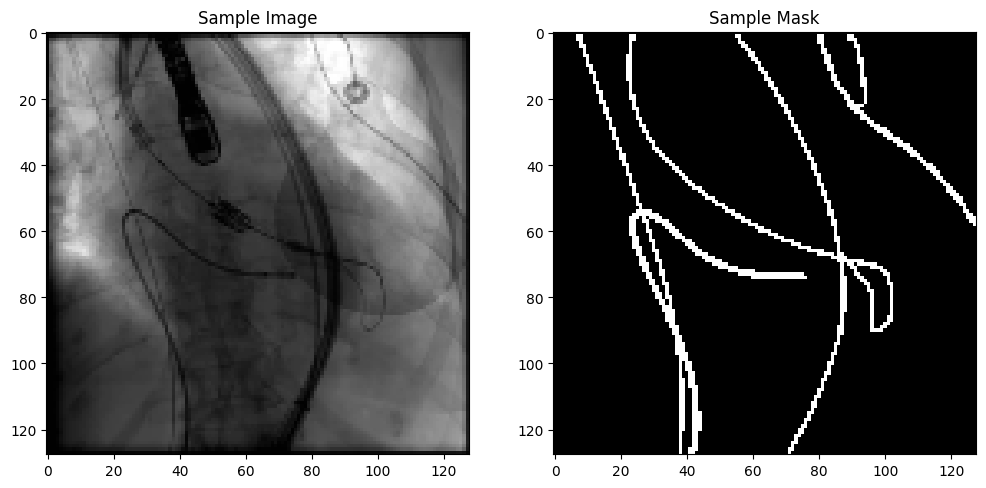

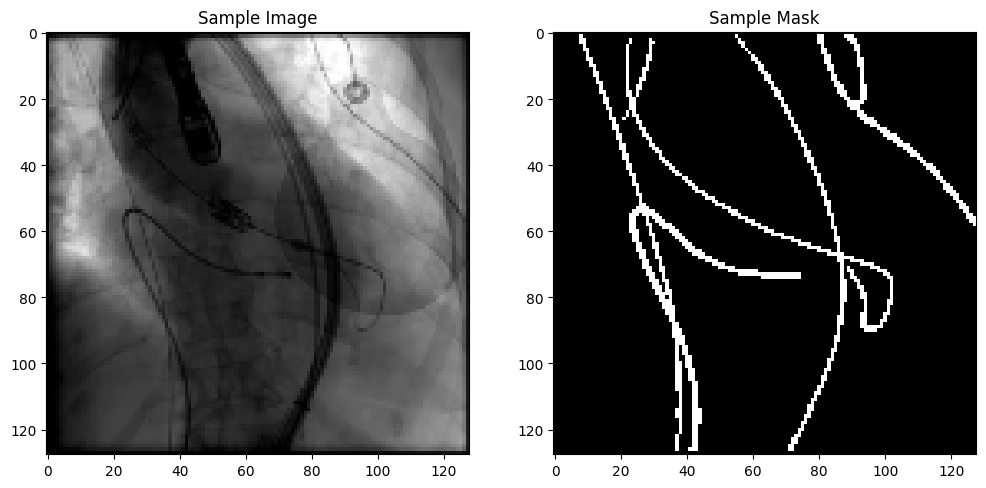

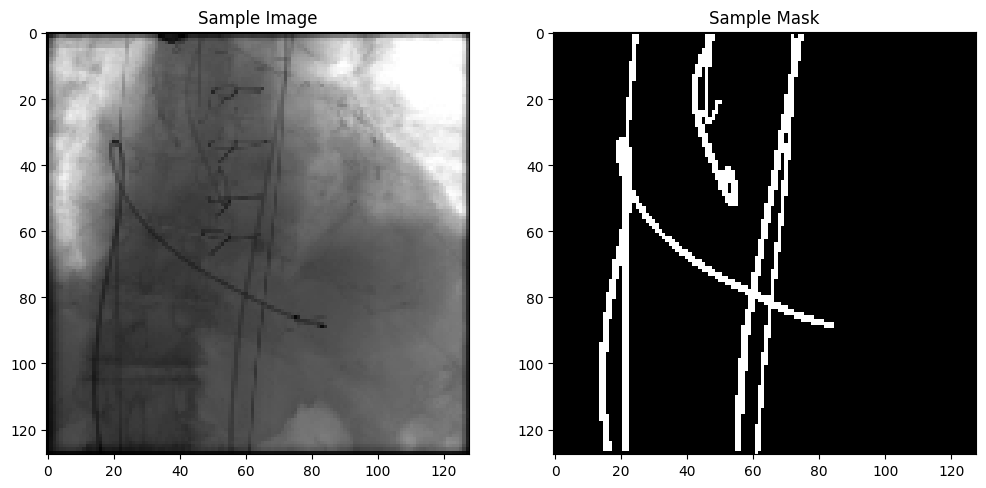

In [ ]:
def visualize_samples(dataset, num_samples=3):
    for i in range(num_samples):
        image, mask = dataset[i]
        image = image.numpy().squeeze()  # Assuming image shape is [1, H, W]
        mask = mask.numpy().squeeze()  # Assuming mask shape is [1, H, W]

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(image, cmap='gray')
        axes[0].set_title('Sample Image')
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('Sample Mask')
        plt.show()

# Visualize some samples from the unseen dataset
visualize_samples(unseen_dataset)

Loaded image from /content/drive/My Drive/TestData2/T2_Image_150_Fluoroscopy_Image_149.png with shape (128, 128, 4) and unique values: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  20  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36  38
  40  42  43  44  46  47  48  50  51  52  54  55  56  58  60  62  63  64
  65  67  68  69  70  71  72  73  75  76  77  79  80  81  83  84  85  86
  87  88  89  91  92  93  94  95  96  97  99 100 101 102 103 104 105 107
 108 109 110 111 112 113 115 116 117 119 120 121 123 124 125 126 127 128
 129 130 131 133 134 135 136 138 139 140 141 142 143 144 145 146 147 149
 150 151 152 153 154 155 156 158 159 160 161 162 163 165 166 167 168 169
 170 171 172 173 174 175 176 178 179 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 213 214 215 217 218 219 220 221 222 223 224 225 226 227 229
 230 231 232 233 234 235 237 238 239 241 242 243 247 249 250 2

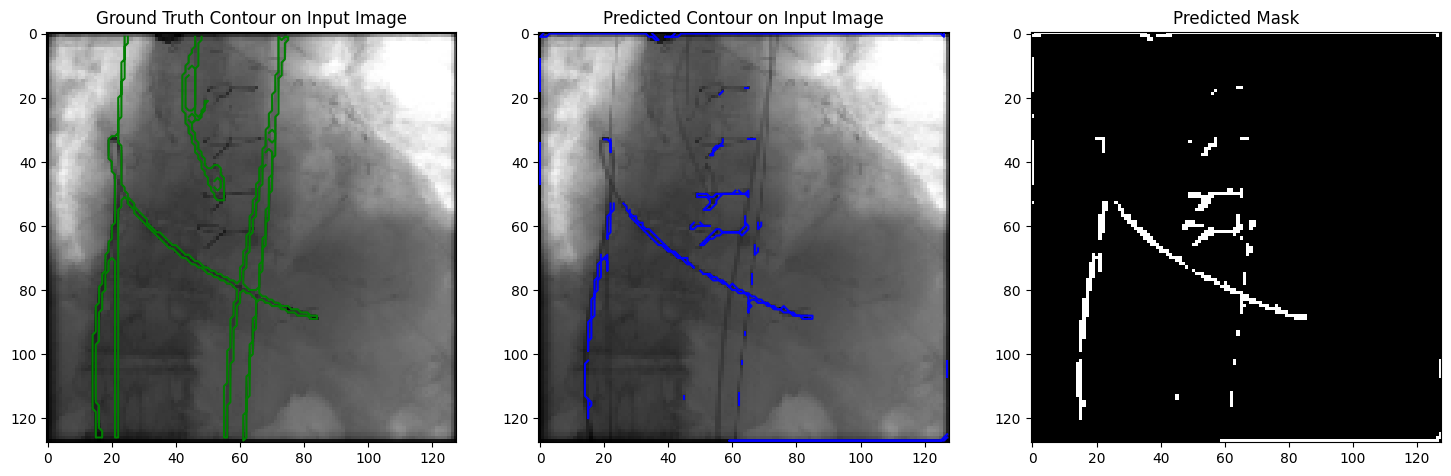

Block 0 Output: 0.3495684266090393, 0.0, 5.659995079040527
Block 1 Output: 0.3772956132888794, 0.0, 6.8469085693359375
Block 2 Output: 0.366058886051178, 0.0, 8.519808769226074
Block 3 Output: 0.4404943883419037, 0.0, 3.7909657955169678
Block 4 Output: 0.42312681674957275, 0.0, 5.097625255584717
Block 5 Output: 0.40622395277023315, 0.0, 4.684972763061523
Block 6 Output: 0.6183503270149231, 0.0, 10.4395170211792
Prediction 0_0: Model output min 0.0, max 1.0, mean 0.04156494140625
Prediction 0_0: Ground truth mask min 0.0, max 1.0, mean 0.06829833984375


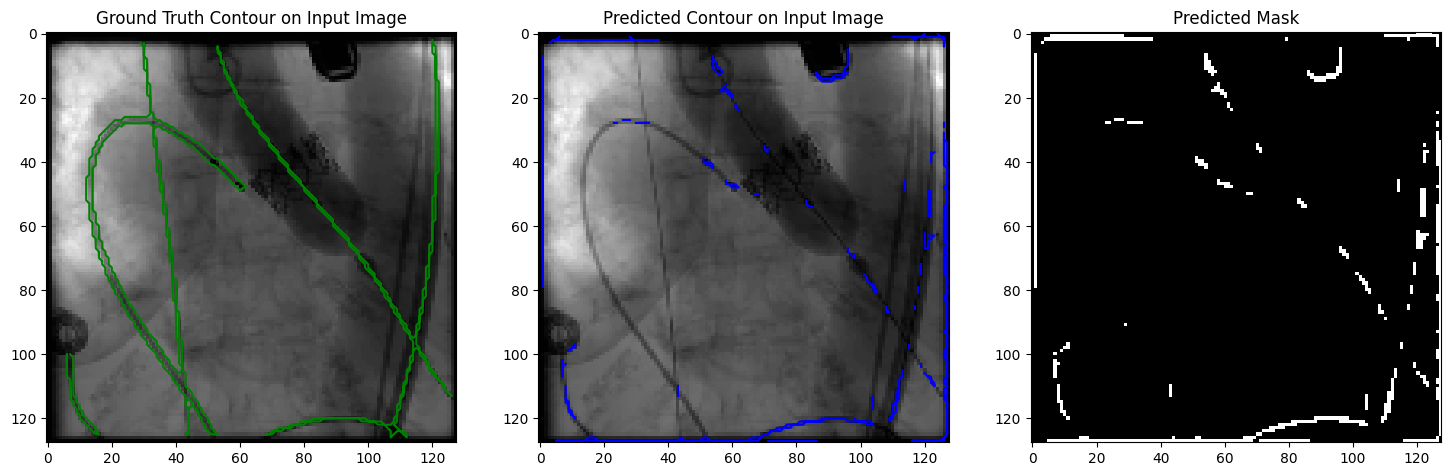

Block 0 Output: 0.3599841594696045, 0.0, 5.746436595916748
Block 1 Output: 0.3849705457687378, 0.0, 6.371688365936279
Block 2 Output: 0.377142071723938, 0.0, 8.398741722106934
Block 3 Output: 0.4313391149044037, 0.0, 5.439287185668945
Block 4 Output: 0.42605501413345337, 0.0, 6.547489643096924
Block 5 Output: 0.40997034311294556, 0.0, 4.453446865081787
Block 6 Output: 0.6153832077980042, 0.0, 9.124622344970703
Prediction 1_0: Model output min 0.0, max 1.0, mean 0.0263671875
Prediction 1_0: Ground truth mask min 0.0, max 1.0, mean 0.06451416015625


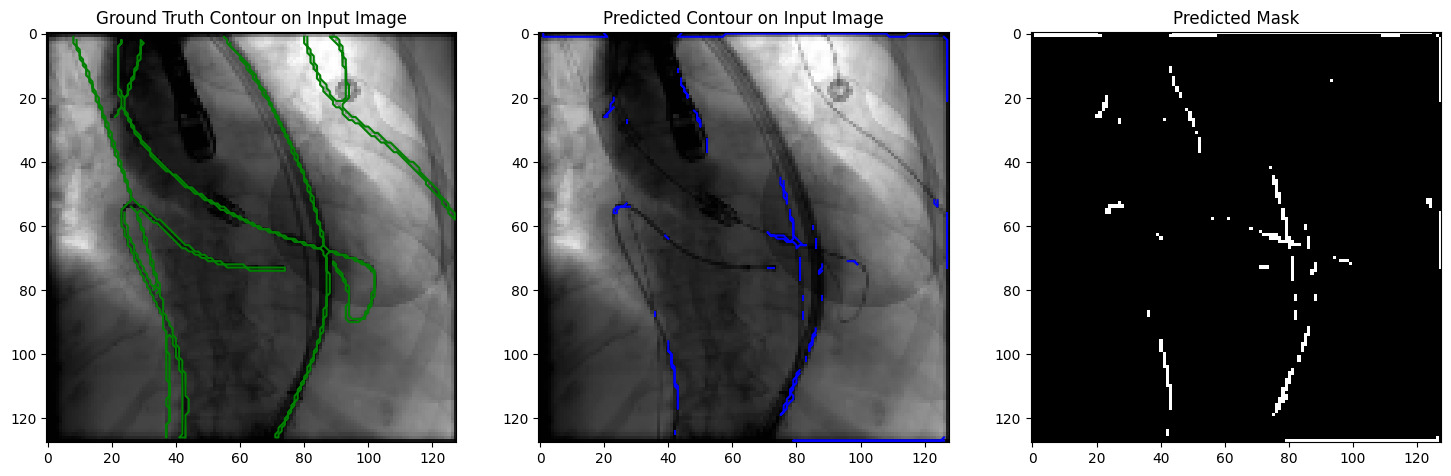

Block 0 Output: 0.3499167859554291, 0.0, 5.631042957305908
Block 1 Output: 0.37725669145584106, 0.0, 6.854243278503418
Block 2 Output: 0.3655494451522827, 0.0, 8.63527774810791
Block 3 Output: 0.4402497708797455, 0.0, 3.857956647872925
Block 4 Output: 0.4230862855911255, 0.0, 5.121623516082764
Block 5 Output: 0.40617913007736206, 0.0, 4.674678325653076
Block 6 Output: 0.6182911396026611, 0.0, 10.835209846496582
Prediction 0_2: Model output min 0.0, max 1.0, mean 0.04046630859375
Prediction 0_2: Ground truth mask min 0.0, max 1.0, mean 0.067138671875


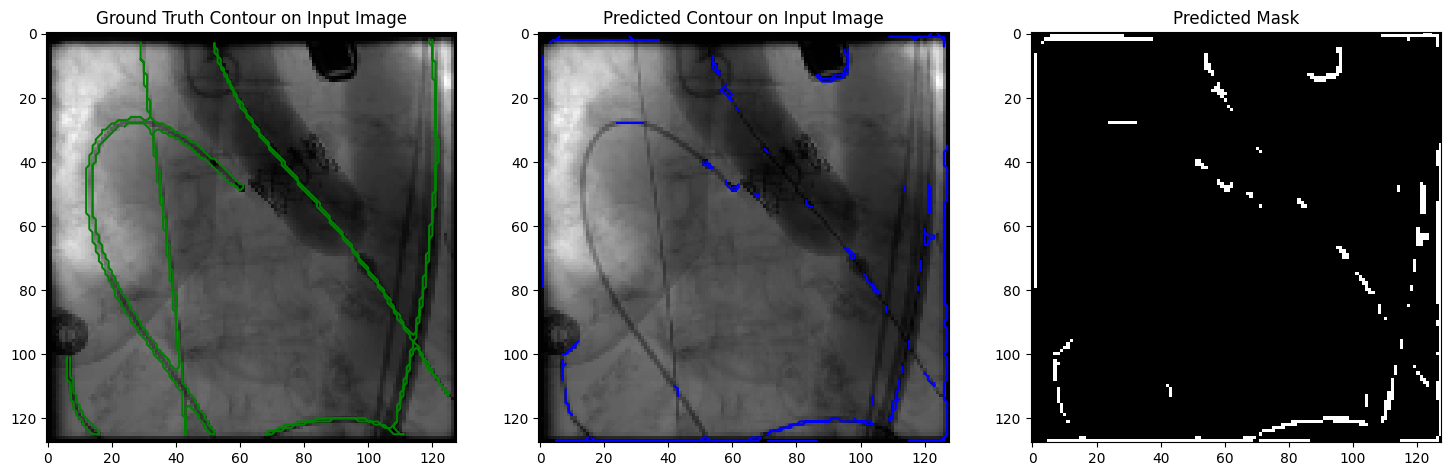

Block 0 Output: 0.3493890166282654, 0.0, 5.620882987976074
Block 1 Output: 0.377028226852417, 0.0, 6.940292835235596
Block 2 Output: 0.36565911769866943, 0.0, 8.65810489654541
Block 3 Output: 0.44025659561157227, 0.0, 3.9145569801330566
Block 4 Output: 0.4229051172733307, 0.0, 5.126430034637451
Block 5 Output: 0.4063202738761902, 0.0, 4.705132484436035
Block 6 Output: 0.6181734800338745, 0.0, 10.131953239440918
Prediction 0_1: Model output min 0.0, max 1.0, mean 0.0416259765625
Prediction 0_1: Ground truth mask min 0.0, max 1.0, mean 0.06494140625


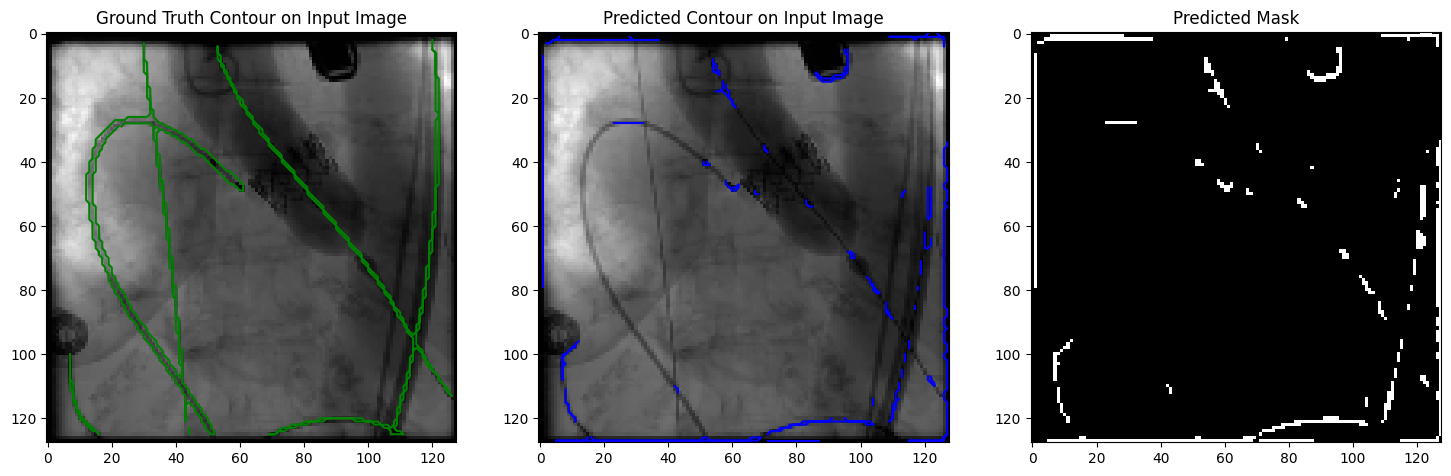

Block 0 Output: 0.358748197555542, 0.0, 5.948338031768799
Block 1 Output: 0.3843095302581787, 0.0, 5.961036682128906
Block 2 Output: 0.3845406770706177, 0.0, 6.78746223449707
Block 3 Output: 0.44057244062423706, 0.0, 3.868819236755371
Block 4 Output: 0.4269714951515198, 0.0, 5.0800909996032715
Block 5 Output: 0.4101572632789612, 0.0, 4.516489028930664
Block 6 Output: 0.612717866897583, 0.0, 10.649335861206055
Prediction 0_3: Model output min 0.0, max 1.0, mean 0.0400390625
Prediction 0_3: Ground truth mask min 0.0, max 1.0, mean 0.06268310546875


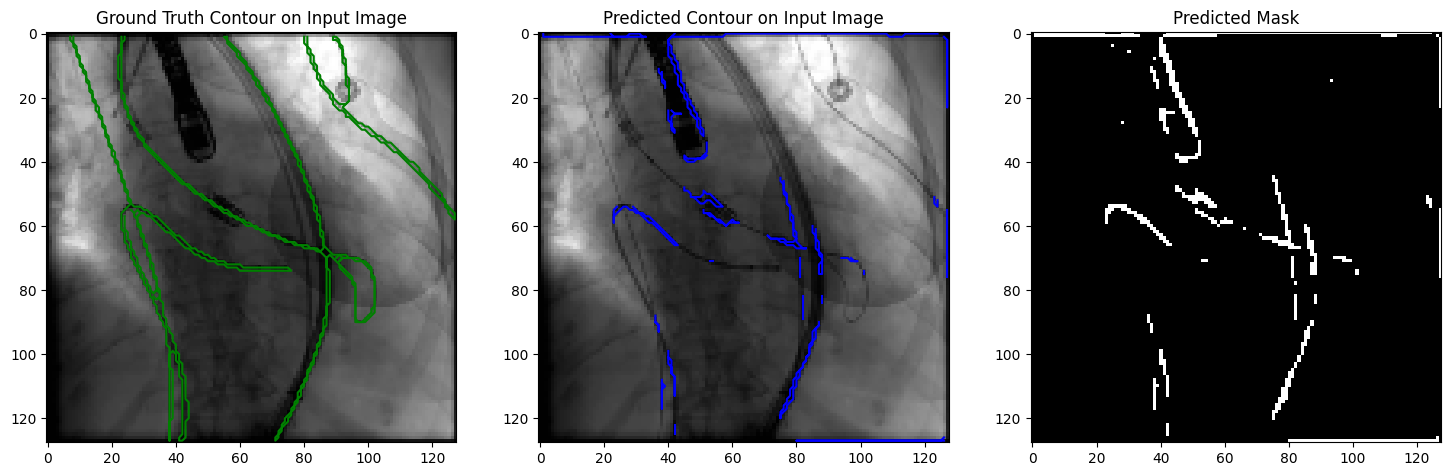

finish!
Mean IoU: 0.11705017959078153, Mean Dice: 0.20846273005008698, Mean RDice: 0.20846273005008698, Mean clDice: 0.27984433453936997, Mean AUC: 0.5673487958380894


In [ ]:
import random
import numpy as np
import os
import torch
import matplotlib.pyplot as plt

def predict_and_visualize(model, loader, save_path, args):
    model.eval()
    iou_scores = []
    dice_scores = []
    rdice_scores = []
    cl_dice_scores = []
    auc_scores = []

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Collect all samples in a list for random sampling
    all_samples = []

    for batch_idx, (images, masks) in enumerate(loader):
        images = images.numpy()
        masks = masks.numpy()

        for t in range(images.shape[0]):
            all_samples.append((batch_idx, t, images[t], masks[t]))

    # Select 8 random samples from the collected list
    selected_samples = random.sample(all_samples, min(8, len(all_samples)))

    for batch_idx, t, image, mask in selected_samples:
        image = image[0]  # Assuming image shape is [1, H, W]
        mask = mask[0]  # Assuming mask shape is [1, H, W]

        name = f"prediction_{batch_idx}_{t}.png"  # Creates a filename for the prediction output
        y, x = image.shape

        # Initialize prediction and normalization map
        ind = (max(y, x) // args.ROI_shape + 1) * args.ROI_shape
        predict = np.zeros([1, args.n_classes, y, x], dtype=np.float32)
        n_map = np.zeros([1, args.n_classes, y, x], dtype=np.float32)

        # Create the map kernel
        shape = (args.ROI_shape, args.ROI_shape)
        a = np.zeros(shape=shape)
        a = np.where(a == 0)
        map_kernal = 1 / ((a[0] - shape[0] // 2)**4 + (a[1] - shape[1] // 2)**4)
        map_kernal = np.reshape(map_kernal, newshape=(1, 1) + shape)

        image = image[np.newaxis, np.newaxis, :, :]
        stride_x = shape[0] // 2
        stride_y = shape[1] // 2

        # Process the image in overlapping patches
        for i in range((y - shape[0]) // stride_x + 1):
            for j in range((x - shape[1]) // stride_y + 1):
                image_i = image[:, :, i * stride_x:i * stride_x + shape[0],
                                j * stride_y:j * stride_y + shape[1]]
                image_i = torch.from_numpy(image_i)
                if torch.cuda.is_available():
                    image_i = image_i.cuda()
                output = model(image_i)
                output = output.data.cpu().numpy()

                predict[:, :, i * stride_x:i * stride_x + shape[0],
                        j * stride_y:j * stride_y + shape[1]] += (output * map_kernal)
                n_map[:, :, i * stride_x:i * stride_x + shape[0],
                      j * stride_y:j * stride_y + shape[1]] += map_kernal

        output = predict / n_map
        output = output.astype(dtype=np.float32)
        output_final = np.zeros([1, args.n_classes, y, x], dtype=np.float32)
        output_final[:, :, 0:y, 0:x] = output[:, :, 0:y, 0:x]

        # Binarize the predicted mask
        output_final[0][0] = (output_final[0][0] > 0.5).astype(np.uint8)

        # Debug output range
        print(f"Prediction {batch_idx}_{t}: Model output min {output_final[0][0].min()}, max {output_final[0][0].max()}, mean {output_final[0][0].mean()}")
        print(f"Prediction {batch_idx}_{t}: Ground truth mask min {mask.min()}, max {mask.max()}, mean {mask.mean()}")

        # Save prediction as .png
        plt.imsave(os.path.join(save_path, name), output_final[0][0], cmap='gray')

        # Check if masks are not empty
        if output_final[0][0].sum() == 0 or mask.sum() == 0:
            print(f"Empty mask detected for image {batch_idx}_{t}. Skipping IoU and Dice calculation.")
            continue

        # Calculate metrics
        iou = iou_score(torch.from_numpy(output_final[0][0]), torch.from_numpy(mask))
        dice = dice_coefficient(torch.from_numpy(output_final[0][0]), torch.from_numpy(mask))
        rdice = rdice_coefficient(torch.from_numpy(output_final[0][0]), torch.from_numpy(mask))
        cl_dice = cl_dice_coefficient(torch.from_numpy(output_final[0][0]), torch.from_numpy(mask))
        auc = auc_score(torch.from_numpy(output_final[0][0]), torch.from_numpy(mask))

        iou_scores.append(iou)
        dice_scores.append(dice)
        rdice_scores.append(rdice)
        cl_dice_scores.append(cl_dice)
        auc_scores.append(auc)

        # Extract contours
        ground_truth_contours = extract_contours(mask)
        predicted_contours = extract_contours(output_final[0][0])

        # Visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        axes[0].imshow(image.squeeze(), cmap='gray')  # Use squeeze to ensure 2D shape
        for contour in ground_truth_contours:
            axes[0].plot(contour[:, 0, 0], contour[:, 0, 1], 'g')  # Ground truth in green
        axes[0].set_title('Ground Truth Contour on Input Image')

        axes[1].imshow(image.squeeze(), cmap='gray')  # Use squeeze to ensure 2D shape
        for contour in predicted_contours:
            axes[1].plot(contour[:, 0, 0], contour[:, 0, 1], 'b')  # Predicted in blue
        axes[1].set_title('Predicted Contour on Input Image')

        axes[2].imshow(output_final[0][0].squeeze(), cmap='gray')  # Use squeeze to ensure 2D shape
        axes[2].set_title('Predicted Mask')

        plt.show()

    print("finish!")
    mean_iou = np.mean(iou_scores)
    mean_dice = np.mean(dice_scores)
    mean_rdice = np.mean(rdice_scores)
    mean_cl_dice = np.mean(cl_dice_scores)
    mean_auc = np.mean(auc_scores)
    print(f"Mean IoU: {mean_iou}, Mean Dice: {mean_dice}, Mean RDice: {mean_rdice}, Mean clDice: {mean_cl_dice}, Mean AUC: {mean_auc}")


# Testing function
def test_model_on_unseen_data(net, unseen_loader, args):
    predict_and_visualize(net, unseen_loader, args.save_path_max, args)

# Assuming args is defined and net is the trained DSCNet model
args = Args()  # Define your Args object if not already defined

# Example usage
image_folder_path = [
    '/content/drive/My Drive/TestData2'

]
image_prefix = 'Fluoroscopy_Image'
mask_prefix = 'Annotation'  # If masks are available for validation
image_size = (128, 128)

# Load the unseen data
unseen_dataset = Dataloader(image_folder_path, image_prefix, mask_prefix, image_size)
unseen_loader = torch.utils.data.DataLoader(unseen_dataset, batch_size=4, shuffle=False)

# Test the model on unseen data
test_model_on_unseen_data(net, unseen_loader, args)
